<h1> DYNAMIC MALWARE CLASSIFICATION</h1>

Supervised, classification, multi-class

# 0. Basic Set-Up and General info

Note: there are a lot of non-used imports (to be removed at the end)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy import stats

import copy

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [3]:
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy


In [4]:
import importlib

# Import your modules initially
import library.pipeline

# Reload the modules in case they were updated
importlib.reload(library.pipeline)

# Now you can import specific classes/functions
from library.pipeline.pipeline import Pipeline
from library.pipeline.pipeline_manager import PipelineManager

## Documentation Standarization
Follow the following guidelines to make sure our document is consistent and easier to undestand
- All constant should be writte in full capitall letters (e.g: MY_CONSTANT). Notebook-level constants should be written in the cell assigned to it (see below)
- Every new major section (EDA, Feature engineering) should be written with '# My title'#
- Subsequent sections should use '##', '###' or '####' hierarchacically
- At the beginning of each major section write a content index with the content included in that section (see 'feature engineering' section as an example)
- Please write paragraphs before and after each cell explain what u are about to do and the conclusions, correspondingly. Do not assume they are too obvious.
- Avoid excessive ChatGPT-originated comments
- Avoid writing more than 20 lines per code cell (exceptions for subroutines, which should be written in utilitied_functions.py)
- Ideally, add a "Questions" and "Things to be done" section in each major sections where u write about futher iterations u want to do (while sharing in with the rest)


## Set-up

In [5]:
dataset_path ="./dataset/dynamic_dataset.csv"
results_path = "results/results.csv"

We start off with a pipeline for all the models. Then at some moment, whenever we think the pipelines will diverge, we remove the by-object-refrence (that we will create in the next cell), and create a new copy with our modifications ready.

In [6]:
default_pipeline = ensembled_pipeline = tree_pipeline = linear_pipeline = baseline_pipeline = example = Pipeline(
                        dataset_path=dataset_path, 
                        results_path=results_path,
                        model_type="classification")

In [7]:
pipelines = {
            "not-baseline": {
                  "ensembled": ensembled_pipeline,
                  "tree-based": tree_pipeline,
                  "linear": linear_pipeline,
                  }, 
            "baseline": {
                  "logistic": baseline_pipeline, 
                  "example":  example               
            }
}
pipeline_manager = PipelineManager(pipelines)

Here I show an example of how we will be working with by-object-reference.

In [8]:
baseline_pipeline.dataset.example_attribute = "1"

In [9]:
default_pipeline.dataset.example_attribute

'1'

However, if we do a (deep) copy:
Note that the difference between a deep and a shallow copy is that the former copies all the objects that are inside the class. We need that.
We will overwrite the prior attribute and show is this is not propagated to the other results anymore

In [10]:
new_pipeline = copy.deepcopy(default_pipeline)
new_pipeline.dataset.example_attribute = "2"

In [11]:
default_pipeline.dataset.example_attribute

'1'

It may also be of interest for you to propagate the same method's invokation to all the pipelines within the pipeline manager. For instance, after a divergence in, lets say, feature scaling, you may need to fit all the models in the corresponding pipelines. You would want to avoid reduntandly calling the same method with the same parameters for all the Pipeline class instances. In order to do so, we present an example that avoids such annoyance

In [12]:
pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="example", print_results=True)

Pipeline example in category baseline has diverged
 Pipeline schema is now: {'not-baseline': {'ensembled': <library.pipeline.pipeline.Pipeline object at 0x1238845d0>, 'tree-based': <library.pipeline.pipeline.Pipeline object at 0x1238845d0>, 'linear': <library.pipeline.pipeline.Pipeline object at 0x1238845d0>}, 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline object at 0x1238845d0>, 'example': <library.pipeline.pipeline.Pipeline object at 0x124605710>}}


In [13]:
pipeline_manager.pipelines["baseline"]["example"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd")

Whats goooddd from 4905261200. You are at automatic feature selection!


In [14]:
pipeline_manager.all_pipelines_execute(methodName="speak", message="Hello, world!")

Hello, world! from 4891100624
Pipeline ensembled in category not-baseline has executed speak. Result is: None
Hello, world! from 4905260816
Pipeline example in category baseline has executed speak. Result is: None


{'not-baseline': {'ensembled': None}, 'baseline': {'example': None}}

A method present deeper down the class:

Instead of doing:
'pipeline_manager.pipelines["baseline"]["logistic"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd") for all objects'

we can do:

In [15]:
pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_selection.automatic_feature_selection.speak", message="Whats good")

Whats good from 4905813008. You are at automatic feature selection!
Pipeline ensembled in category not-baseline has executed feature_analysis.feature_selection.automatic_feature_selection.speak. Result is: None
Whats good from 4905261200. You are at automatic feature selection!
Pipeline example in category baseline has executed feature_analysis.feature_selection.automatic_feature_selection.speak. Result is: None


{'not-baseline': {'ensembled': None}, 'baseline': {'example': None}}

In [16]:
# lets delete the example obj
del new_pipeline 
del pipeline_manager.pipelines["baseline"]["example"]

In [17]:
pipeline_manager.pipelines

{'not-baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x1238845d0>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x1238845d0>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x1238845d0>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x1238845d0>}}

<hr>

# Start Of The Pipeline

In [18]:
default_pipeline.dataset.df.head()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  Memory_PrivateDirty  \
0            31053             2448               14044                23472   
1           107787            21976               11852                74548   
2            86584            18460               12284                59992   
3            41248              924               10328                36280   
4            38621             5080               12392                27388   

   Memory_SharedClean  Memory_PrivateClean  Memory_SwapPssDirty  \
0               74824                 2452                    0   
1               69052                23152                    0   
2               91548                19376                    0   
3               55768                  928                    0   
4               71048                 5088                    0   

   Memory_HeapSize  Memory_HeapAlloc  Memory_HeapFree  ...  Logcat_error  \
0             8919              4786             4132  ...          1635   
1            25341             20965             4375  ...          1816   
2            24500             21378             3121  ...          2244   
3            10082              7281             2800  ...           974   
4             9077              5750             3326  ...           936   

   Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  Process_total  \
0            2351          3285            1551         11221            193   
1             826          1544            2045          8457            189   
2            3406          1565            2819         10780            195   
3            4134          3138            1556         11739            191   
4            2298          3752            1992         10488            188   

                                                Hash    Category    Family  \
0  f460abb8f2e4e3fb689966ddaea6d6babbd1738bb691c7...  Trojan_SMS    opfake   
1  556c238536d837007e647543eaf3ea95ae9aaf1c1a52d0...  Trojan_SMS    opfake   
2  398322f94b5bfa2a9e7b3756a4cf409764595003280c48...  Trojan_SMS  fakeinst   
3  4a9c14872b2c66165599a969a1a8654bb6887d7a18ab6d...  Trojan_SMS  fakeinst   
4  6b37b9b9c170727f706b69731e64da4bbca2638b4237a7...  Trojan_SMS  fakeinst   

   reboot  
0  before  
1  before  
2  before  
3  before  
4  before  

[5 rows x 145 columns]

In [19]:
for col in default_pipeline.dataset.df.columns.to_list():
    print(col)

Memory_PssTotal
Memory_PssClean
Memory_SharedDirty
Memory_PrivateDirty
Memory_SharedClean
Memory_PrivateClean
Memory_SwapPssDirty
Memory_HeapSize
Memory_HeapAlloc
Memory_HeapFree
Memory_Views
Memory_ViewRootImpl
Memory_AppContexts
Memory_Activities
Memory_Assets
Memory_AssetManagers
Memory_LocalBinders
Memory_ProxyBinders
Memory_ParcelMemory
Memory_ParcelCount
Memory_DeathRecipients
Memory_OpenSSLSockets
Memory_WebViews
API_Process_android.os.Process_start
API_Process_android.app.ActivityManager_killBackgroundProcesses
API_Process_android.os.Process_killProcess
API_Command_java.lang.Runtime_exec
API_Command_java.lang.ProcessBuilder_start
API_JavaNativeInterface_java.lang.Runtime_loadLibrary
API_JavaNativeInterface_java.lang.Runtime_load
API_WebView_android.webkit.WebView_loadUrl
API_WebView_android.webkit.WebView_loadData
API_WebView_android.webkit.WebView_loadDataWithBaseURL
API_WebView_android.webkit.WebView_addJavascriptInterface
API_WebView_android.webkit.WebView_evaluateJavascript

In [20]:
default_pipeline.dataset.df["Category"].value_counts()

Category
Riskware          14053
Adware            10980
Trojan             8437
Zero_Day           4475
Ransomware         3411
Trojan_Spy         2840
Trojan_SMS         1939
No_Category        1932
Trojan_Dropper     1570
PUA                1290
Backdoor           1137
Scareware           886
FileInfector        248
Trojan_Banker       241
Name: count, dtype: int64

In [21]:
default_pipeline.dataset.df.rename(columns={"reboot": "Reboot"}, inplace=True) # consistency with other features' names
default_pipeline.dataset.df.drop(columns=["Family", "Hash"], inplace=True) # We have decided to use only category as target variable; Hash is temporary while im debugging (it will be deleted in EDA)

### Description of our features

For each of our entries in the dataset we have a feature describing the state of the (operating) system under which the malware was running. Here is an intial description for each of them.
Please access this document for a complete problem context description: https://docs.google.com/document/d/1yH9gvnJVSH9GLv9ATQ5JQWA2z8Jy4umxxRfMF-y2fiU/edit?usp=sharing

# 1. EDA

This section below shall be deleted

In [22]:
default_pipeline.data_preprocessing.remove_duplicates()

No duplicates found in the dataset


In [23]:
default_pipeline.data_preprocessing.get_missing_values()

No missing values found in the dataset


In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


### SUGGESTIONS FOR IMPROVEMENTS
- Cluster analysis

<hr>

# 2. DATA SPLITTING
### TO BE DONE
- Statistical analysis of this
- Make sure they follow the same distributions

### Data Splitting: Category as target variable
Originally, we will focus only on category

Lets first get the X and y extracted from our dataset

Also object!
Lets get back to the splitting!

Before, we split the dataset lets observe the SE of accuracy variation based on our choice of split. 
Brief explanation: we can model accuracy via a Binomial distribution. We know each event in a binomial distribution can be modelled through a bernoulli distribution, where the outcome represents the probability predicting the correct class or not. We make the assumption that each classification error is independent from each other. For:
$$
\text{Bin} \sim (n, p)
$$
 let us assume that the parameter of this distribution is p = .85 and n is given by the choice of sample split for the test set. The SE of the sample proportion can be modeled via: 
$$
\text{SE}_{\hat{p}} = \sqrt{\frac{p(1 - p)}{n}}

$$

Before we continue to assess all possible choices of split based on a variant n, also note that that choice of evenly distributed split (e.g: 10% for each hold-out set) between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.

Finally, also note that that choice of evenly distributed split between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/phases/dataset/split/strategies/noTimeSeries.py:112: RuntimeWarning: divide by zero encountered in scalar divide
  differenceToPriorSE_percentage = (currentSE - priorSE) /  priorSE


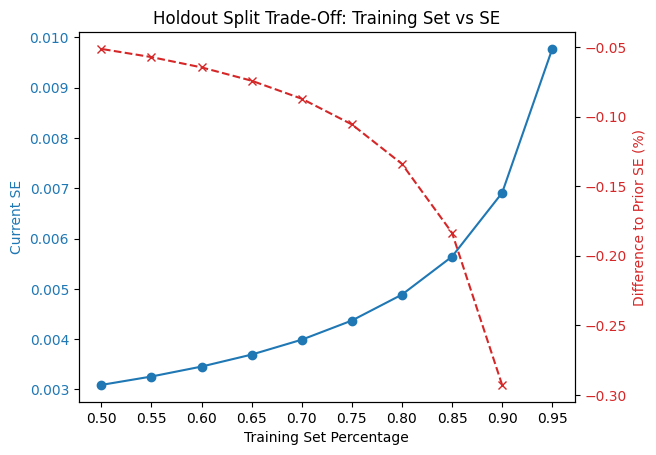

train_size (%)  train_size_count  validation_size (%)  \
0            0.95           50767.0                0.025   
1            0.90           48095.0                0.050   
2            0.85           45423.0                0.075   
3            0.80           42751.0                0.100   
4            0.75           40079.0                0.125   
5            0.70           37407.0                0.150   
6            0.65           34735.0                0.175   
7            0.60           32063.0                0.200   
8            0.55           29391.0                0.225   
9            0.50           26720.0                0.250   

   validation_size_count  test_size (%)  test_size_coount  currentSE  \
0                 1336.0          0.025            1336.0   0.009769   
1                 2672.0          0.050            2672.0   0.006908   
2                 4008.0          0.075            4008.0   0.005640   
3                 5344.0          0.100            5344.0   0.004885   
4                 6680.0          0.125            6680.0   0.004369   
5                 8016.0          0.150            8016.0   0.003988   
6                 9352.0          0.175            9352.0   0.003692   
7                10688.0          0.200           10688.0   0.003454   
8                12024.0          0.225           12024.0   0.003256   
9                13360.0          0.250           13360.0   0.003089   

   differenceToPriorSE  differenceToPriorSE (%)  
0             0.009769                      inf  
1            -0.002861                -0.292893  
2            -0.001268                -0.183503  
3            -0.000756                -0.133975  
4            -0.000516                -0.105573  
5            -0.000381                -0.087129  
6            -0.000296                -0.074180  
7            -0.000238                -0.064586  
8            -0.000198                -0.057191  
9            -0.000167                -0.051317

In [24]:
default_pipeline.dataset.split.asses_split_classifier(p=.85, step=.05, plot=True)

[We can see a diminishing-returns class graph](https://en.wikipedia.org/wiki/Knee_of_a_curve). The more we decline the training set percentage the slower and more steadier the current SE varies as well as the difference to prior SE, in percentage. We can see that the knee in the curve is between 80 and 90 training set percentage. This represents the area where when you start going below the lower bound, no **significant** improve appears. Given the fact that our criteria for choice of split percentage is to keep as much training possible while increasing hold-out sets size only if the decrease in SE is significant **we are going to select 80% for the training set**.

In [25]:
default_pipeline.dataset.split.split_data(y_column="Category",
                                   train_size=.8, 
                                   validation_size=.1,
                                   test_size=.1, 
                                   plot_distribution=False)

In [26]:
default_pipeline.dataset.X_train.shape, default_pipeline.dataset.X_val.shape, default_pipeline.dataset.X_test.shape, default_pipeline.dataset.y_train.shape, default_pipeline.dataset.y_val.shape, default_pipeline.dataset.y_test.shape

((42751, 142), (5344, 142), (5344, 142), (42751,), (5344,), (5344,))

<hr>

# 3. DATA PREPROCESSING

### Feature Scaling

We will work only with the training set to avoid data leakage.

In [27]:
#dataset.X_train

We eliminate the field `Reboot_before` since it is boolean.

In [28]:
# preprocessor.remove_reboot_column()
# preprocessor.X_train_without_reboot

In [29]:
# preprocessor.X_train_without_reboot.describe().T[['min', 'max']]

Secondly, we're gonna check for kurtosis and skewness. If skewness is high we might need to consider standardizing.

In [30]:
# print(f"\nSkewness:\n----------------\n{preprocessor.X_train_without_reboot.skew()}")
# print(f"\nKurtosis:\n----------------\n{preprocessor.X_train_without_reboot.kurt()}")

Since there is a very large number of fields, we need to avoid looking at the distribution and information about each feature. For this, we decided to create an automation that decides the appropriate scaling method -if necessary- for each feature.

This function `determine_scaling_method` takes into account outlier detection and skewness and based on that it decides to use a **robust scaler**, **normalize** or **none**.

**Note**: we use robust scaler rather than a standard scaler because robust scales with the median and IQR, which is less sensitive to outliers than standardizing is -computed with $\mu$ and $\sigma$. It will turn the median to 0 and turn the values in a field in values between -1 and 1 with some outliers.

Normalization Formula:
 

Robust Scaler Formula:
 
Where:

IQR (Interquartile Range) = Q3 - Q1

In [31]:
# preprocessor.prepare_scaling()

In [32]:
# X_train_scaled = preprocessor.apply_scaling()

# "\nRobust complete! The training data is now ready for modeling."

In [33]:
# X_train_scaled

The histograms show how `RobustScaler` compresses extreme values and brings the bulk of the data closer to a common scale. Despite the presence of outliers, the core distribution becomes more uniform and comparable across features — ideal for many ML models.

## Handling class imbalance

In [34]:
# Temporaray fix

In [35]:
default_pipeline.dataset.X_train.shape

(42751, 142)

In [36]:
#class_imbalance_perPipeline = pipeline_manager.all_pipelines_execute(methodName="data_preprocessing.class_imbalance", verbose=True)

In [37]:
default_pipeline.dataset.X_train.shape

(42751, 142)

In [38]:
pipeline_manager.pipelines["not-baseline"]["ensembled"].dataset.X_train.dtypes

Memory_PssTotal         int64
Memory_PssClean         int64
Memory_SharedDirty      int64
Memory_PrivateDirty     int64
Memory_SharedClean      int64
                        ...  
Logcat_debug            int64
Logcat_verbose          int64
Logcat_total            int64
Process_total           int64
Reboot                 object
Length: 142, dtype: object

<hr>

This section below shall be properly written. It is set now for early debugging

## !> Pipeline example
Let us show an example of the pipeline divergence. We will create a divergence for the baseline pipeline. We will exempt it from being scaled. This specific example is not meant to be kept, but rather show the purpose of the corresponding functions.

In [39]:
baseline_pipeline = pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="logistic")

In [40]:
default_pipeline.dataset.X_train.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     42751.000000     42751.000000        42751.000000   
mean      70944.886272     12764.341700        10844.857898   
std       36266.506343     12900.070827          999.033790   
min        4808.000000         0.000000         7036.000000   
25%       46185.000000      3972.000000        10540.000000   
50%       61243.000000      6356.000000        10732.000000   
75%       91785.000000     20048.000000        11144.000000   
max      819456.000000    106360.000000        40416.000000   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         42751.000000        42751.000000         42751.000000   
mean          47646.187738        88029.087694         14333.172277   
std           29793.858149        15871.265926         13468.721351   
min              12.000000         4268.000000             0.000000   
25%           31992.000000        76716.000000          4984.000000   
50%           41444.000000        89584.000000          8180.000000   
75%           55338.000000        99092.000000         21740.000000   
max          809032.000000       183600.000000        110336.000000   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              42751.0     42751.000000      42751.000000   
mean                   0.0     22278.685996      17539.452434   
std                    0.0     12570.621975      10519.885159   
min                    0.0      5113.000000       3249.000000   
25%                    0.0     13486.500000      10670.000000   
50%                    0.0     20447.000000      16560.000000   
75%                    0.0     28743.500000      22846.500000   
max                    0.0    310155.000000     286959.000000   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     42751.000000  ...                     42751.000000   
mean       4738.241304  ...                       466.232720   
std        2939.327428  ...                      3644.649287   
min        1012.000000  ...                         0.000000   
25%        2994.000000  ...                         0.000000   
50%        4070.000000  ...                        21.000000   
75%        5838.000000  ...                       124.500000   
max       88630.000000  ...                     85873.000000   

       Battery_wakelock  Battery_service    Logcat_info  Logcat_error  \
count      42751.000000     42751.000000   42751.000000  4.275100e+04   
mean           3.396201         0.723235    2337.759865  2.370012e+03   
std            1.518657         0.981457    2203.232434  1.038044e+04   
min            0.000000         0.000000       6.000000  4.000000e+01   
25%            2.000000         0.000000    1159.000000  1.098000e+03   
50%            3.000000         0.000000    2043.000000  2.020000e+03   
75%            4.000000         1.000000    3054.000000  3.028000e+03   
max           12.000000        10.000000  219143.000000  2.066046e+06   

       Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  \
count    42751.000000  42751.000000    42751.000000  4.275100e+04   
mean      2296.848963   2300.166686     2300.399780  1.160519e+04   
std       2273.580562   2031.749201     1976.428885  1.101732e+04   
min         36.000000     45.000000       33.000000  3.121000e+03   
25%       1107.000000   1100.000000     1135.000000  9.422000e+03   
50%       2000.000000   2015.000000     2004.000000  1.097700e+04   
75%       3027.000000   3026.000000     3037.000000  1.299250e+04   
max     142010.000000  89456.000000   102860.000000  2.067038e+06   

       Process_total  
count   42751.000000  
mean      190.169821  
std         2.896415  
min       172.000000  
25%       188.000000  
50%       190.000000  
75%       192.000000  
max       221.000000  

[8 rows x 141 columns]

In [41]:
default_pipeline.data_preprocessing.scale_features(scaler="robust",
                                      columnsToScale=default_pipeline.dataset.X_train.select_dtypes(include=["number"]).columns)

In [42]:
default_pipeline.dataset.X_train.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     42751.000000     42751.000000        42751.000000   
mean          0.212761         0.398628            0.186851   
std           0.795318         0.802443            1.654029   
min          -1.237610        -0.395372           -6.119205   
25%          -0.330219        -0.148296           -0.317881   
50%           0.000000         0.000000            0.000000   
75%           0.669781         0.851704            0.682119   
max          16.627478         6.220702           49.145695   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         42751.000000        42751.000000         42751.000000   
mean              0.265664           -0.069490             0.367222   
std               1.276187            0.709299             0.803815   
min              -1.774694           -3.812835            -0.488183   
25%              -0.404866           -0.575080            -0.190738   
50%               0.000000            0.000000             0.000000   
75%               0.595134            0.424920             0.809262   
max              32.878780            4.201645             6.096682   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              42751.0     42751.000000      42751.000000   
mean                   0.0         0.120055          0.080438   
std                    0.0         0.823925          0.863950   
min                    0.0        -1.005047         -1.093171   
25%                    0.0        -0.456217         -0.483719   
50%                    0.0         0.000000          0.000000   
75%                    0.0         0.543783          0.516281   
max                    0.0        18.988530         22.206628   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     42751.000000  ...                     42751.000000   
mean          0.234965  ...                         3.576166   
std           1.033519  ...                        29.274291   
min          -1.075246  ...                        -0.168675   
25%          -0.378340  ...                        -0.168675   
50%           0.000000  ...                         0.000000   
75%           0.621660  ...                         0.831325   
max          29.732771  ...                       689.574297   

       Battery_wakelock  Battery_service   Logcat_info  Logcat_error  \
count      42751.000000     42751.000000  42751.000000  42751.000000   
mean           0.198101         0.723235      0.155546      0.181353   
std            0.759329         0.981457      1.162656      5.378467   
min           -1.500000         0.000000     -1.074934     -1.025907   
25%           -0.500000         0.000000     -0.466491     -0.477720   
50%            0.000000         0.000000      0.000000      0.000000   
75%            0.500000         1.000000      0.533509      0.522280   
max            4.500000        10.000000    114.564644   1069.443523   

       Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  \
count    42751.000000  42751.000000    42751.000000  42751.000000   
mean         0.154609      0.148062        0.155836      0.175938   
std          1.184157      1.054906        1.039132      3.085652   
min         -1.022917     -1.022845       -1.036278     -2.200252   
25%         -0.465104     -0.475078       -0.456887     -0.435513   
50%          0.000000      0.000000        0.000000      0.000000   
75%          0.534896      0.524922        0.543113      0.564487   
max         72.921875     45.400312       53.026288    575.846800   

       Process_total  
count   42751.000000  
mean        0.042455  
std         0.724104  
min        -4.500000  
25%        -0.500000  
50%         0.000000  
75%         0.500000  
max         7.750000  

[8 rows x 141 columns]

In [43]:
default_pipeline.dataset.X_train.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     42751.000000     42751.000000        42751.000000   
mean          0.212761         0.398628            0.186851   
std           0.795318         0.802443            1.654029   
min          -1.237610        -0.395372           -6.119205   
25%          -0.330219        -0.148296           -0.317881   
50%           0.000000         0.000000            0.000000   
75%           0.669781         0.851704            0.682119   
max          16.627478         6.220702           49.145695   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         42751.000000        42751.000000         42751.000000   
mean              0.265664           -0.069490             0.367222   
std               1.276187            0.709299             0.803815   
min              -1.774694           -3.812835            -0.488183   
25%              -0.404866           -0.575080            -0.190738   
50%               0.000000            0.000000             0.000000   
75%               0.595134            0.424920             0.809262   
max              32.878780            4.201645             6.096682   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              42751.0     42751.000000      42751.000000   
mean                   0.0         0.120055          0.080438   
std                    0.0         0.823925          0.863950   
min                    0.0        -1.005047         -1.093171   
25%                    0.0        -0.456217         -0.483719   
50%                    0.0         0.000000          0.000000   
75%                    0.0         0.543783          0.516281   
max                    0.0        18.988530         22.206628   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     42751.000000  ...                     42751.000000   
mean          0.234965  ...                         3.576166   
std           1.033519  ...                        29.274291   
min          -1.075246  ...                        -0.168675   
25%          -0.378340  ...                        -0.168675   
50%           0.000000  ...                         0.000000   
75%           0.621660  ...                         0.831325   
max          29.732771  ...                       689.574297   

       Battery_wakelock  Battery_service   Logcat_info  Logcat_error  \
count      42751.000000     42751.000000  42751.000000  42751.000000   
mean           0.198101         0.723235      0.155546      0.181353   
std            0.759329         0.981457      1.162656      5.378467   
min           -1.500000         0.000000     -1.074934     -1.025907   
25%           -0.500000         0.000000     -0.466491     -0.477720   
50%            0.000000         0.000000      0.000000      0.000000   
75%            0.500000         1.000000      0.533509      0.522280   
max            4.500000        10.000000    114.564644   1069.443523   

       Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  \
count    42751.000000  42751.000000    42751.000000  42751.000000   
mean         0.154609      0.148062        0.155836      0.175938   
std          1.184157      1.054906        1.039132      3.085652   
min         -1.022917     -1.022845       -1.036278     -2.200252   
25%         -0.465104     -0.475078       -0.456887     -0.435513   
50%          0.000000      0.000000        0.000000      0.000000   
75%          0.534896      0.524922        0.543113      0.564487   
max         72.921875     45.400312       53.026288    575.846800   

       Process_total  
count   42751.000000  
mean        0.042455  
std         0.724104  
min        -4.500000  
25%        -0.500000  
50%         0.000000  
75%         0.500000  
max         7.750000  

[8 rows x 141 columns]

In [44]:
# This is not updated (as expected)
baseline_pipeline.dataset.X_train.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     42751.000000     42751.000000        42751.000000   
mean      70944.886272     12764.341700        10844.857898   
std       36266.506343     12900.070827          999.033790   
min        4808.000000         0.000000         7036.000000   
25%       46185.000000      3972.000000        10540.000000   
50%       61243.000000      6356.000000        10732.000000   
75%       91785.000000     20048.000000        11144.000000   
max      819456.000000    106360.000000        40416.000000   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         42751.000000        42751.000000         42751.000000   
mean          47646.187738        88029.087694         14333.172277   
std           29793.858149        15871.265926         13468.721351   
min              12.000000         4268.000000             0.000000   
25%           31992.000000        76716.000000          4984.000000   
50%           41444.000000        89584.000000          8180.000000   
75%           55338.000000        99092.000000         21740.000000   
max          809032.000000       183600.000000        110336.000000   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              42751.0     42751.000000      42751.000000   
mean                   0.0     22278.685996      17539.452434   
std                    0.0     12570.621975      10519.885159   
min                    0.0      5113.000000       3249.000000   
25%                    0.0     13486.500000      10670.000000   
50%                    0.0     20447.000000      16560.000000   
75%                    0.0     28743.500000      22846.500000   
max                    0.0    310155.000000     286959.000000   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     42751.000000  ...                     42751.000000   
mean       4738.241304  ...                       466.232720   
std        2939.327428  ...                      3644.649287   
min        1012.000000  ...                         0.000000   
25%        2994.000000  ...                         0.000000   
50%        4070.000000  ...                        21.000000   
75%        5838.000000  ...                       124.500000   
max       88630.000000  ...                     85873.000000   

       Battery_wakelock  Battery_service    Logcat_info  Logcat_error  \
count      42751.000000     42751.000000   42751.000000  4.275100e+04   
mean           3.396201         0.723235    2337.759865  2.370012e+03   
std            1.518657         0.981457    2203.232434  1.038044e+04   
min            0.000000         0.000000       6.000000  4.000000e+01   
25%            2.000000         0.000000    1159.000000  1.098000e+03   
50%            3.000000         0.000000    2043.000000  2.020000e+03   
75%            4.000000         1.000000    3054.000000  3.028000e+03   
max           12.000000        10.000000  219143.000000  2.066046e+06   

       Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  \
count    42751.000000  42751.000000    42751.000000  4.275100e+04   
mean      2296.848963   2300.166686     2300.399780  1.160519e+04   
std       2273.580562   2031.749201     1976.428885  1.101732e+04   
min         36.000000     45.000000       33.000000  3.121000e+03   
25%       1107.000000   1100.000000     1135.000000  9.422000e+03   
50%       2000.000000   2015.000000     2004.000000  1.097700e+04   
75%       3027.000000   3026.000000     3037.000000  1.299250e+04   
max     142010.000000  89456.000000   102860.000000  2.067038e+06   

       Process_total  
count   42751.000000  
mean      190.169821  
std         2.896415  
min       172.000000  
25%       188.000000  
50%       190.000000  
75%       192.000000  
max       221.000000  

[8 rows x 141 columns]

### Outliers 

In [45]:
#models_pipeline.preprocessing.get_outliers_df(plot=True)

<hr>

# 4. FEATURE ANALYSIS

Here we will take adjust the features that compose the learning inputs to our model. The correctness of this section is pivotal for proper learning by the model


## FEATURE ENGINEERING
- Domain-specific features
- Binning
- Interaction terms


In [46]:
featuresToEncode = ["Reboot"]

In [47]:
encoded_maps_perPipeline = pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_transformation.get_categorical_features_encoded", verbose=True, features=featuresToEncode, encode_y=True)
pipeline_manager.pipelines_analysis.encoded_map = encoded_maps_perPipeline["baseline"]["logistic"] # setting baseline as an arbitrary example (all are the same as for now)

Pipeline logistic in category baseline has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'No_Category': 3, 'PUA': 4, 'Ransomware': 5, 'Riskware': 6, 'Scareware': 7, 'Trojan': 8, 'Trojan_Banker': 9, 'Trojan_Dropper': 10, 'Trojan_SMS': 11, 'Trojan_Spy': 12, 'Zero_Day': 13}
Pipeline ensembled in category not-baseline has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'No_Category': 3, 'PUA': 4, 'Ransomware': 5, 'Riskware': 6, 'Scareware': 7, 'Trojan': 8, 'Trojan_Banker': 9, 'Trojan_Dropper': 10, 'Trojan_SMS': 11, 'Trojan_Spy': 12, 'Zero_Day': 13}


Lets visualize the results of the encoding...

In [48]:
default_pipeline.dataset.X_train

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
48143        -0.572982        -0.212739            3.662252   
10388         0.223136         0.310774           -2.933775   
11029         1.298399         1.525006           -0.046358   
36609        -0.407325        -0.136850            3.000000   
26413         0.097281        -0.192834            0.099338   
...                ...              ...                 ...   
42697        -0.562982        -0.382433            0.543046   
36008        -0.192939        -0.072157            2.847682   
46265        -0.526820        -0.179895            3.112583   
23587         1.155789         2.092560            0.198675   
29313         0.400395        -0.054740           -0.218543   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
48143            -0.680374           -0.269575            -0.304846   
10388             0.225135           -0.211834             0.196228   
11029             1.288786            1.902038             1.401289   
36609            -0.495674            0.071505            -0.239198   
26413             0.481453            0.522524            -0.129864   
...                    ...                 ...                  ...   
42697            -0.389446           -1.457991            -0.475531   
36008            -0.232845            0.407222            -0.058009   
46265            -0.588366           -0.299428            -0.280019   
23587             0.827551            0.464247             1.995942   
29313             1.075645            0.225778            -0.155168   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
48143                  0.0        -0.744642         -0.903544   
10388                  0.0        -0.345350         -0.408902   
11029                  0.0         1.092089          1.166345   
36609                  0.0        -0.469555         -0.483883   
26413                  0.0         0.760766          0.679752   
...                    ...              ...               ...   
42697                  0.0        -0.748509         -0.895085   
36008                  0.0        -0.160779         -0.123270   
46265                  0.0        -0.681523         -0.782819   
23587                  0.0         1.539293          1.188190   
29313                  0.0         0.471062          0.339014   

       Memory_HeapFree  ...  Battery_wakelock  Battery_service  Logcat_info  \
48143        -0.190928  ...               0.0              0.0     1.229024   
10388        -0.166667  ...              -0.5              2.0    -0.712401   
11029         0.800281  ...              -0.5              1.0     0.200000   
36609        -0.511955  ...               1.0              2.0     0.147757   
26413         1.106188  ...               0.0              0.0     0.120317   
...                ...  ...               ...              ...          ...   
42697        -0.247890  ...               0.0              1.0    -0.127704   
36008        -0.399437  ...               0.0              0.0    -1.018470   
46265        -0.369198  ...               1.0              1.0     0.812137   
23587         3.105837  ...               1.0              0.0    -0.589446   
29313         1.010900  ...               2.5              1.0    -0.645383   

       Logcat_error  Logcat_warning  Logcat_debug  Logcat_verbose  \
48143      0.414508       -0.328646     -0.232606        1.436909   
10388     -0.995337        0.449479     -0.162513        0.420610   
11029      0.486528       -0.559896     -0.995327        0.742376   
36609     -0.969430       -0.633854     -0.031672        0.475289   
26413      2.872539       -0.715625     -0.098131       -0.980547   
...             ...             ...           ...             ...   
42697     -0.263212       -0.177083     -0.367082       -0.841220   
36008      0.315026       -0.623958      0.314642        2.321241   
46265      1.255440       -0.403646     -0.323

In [49]:
default_pipeline.dataset.y_train

48143     8
10388     0
11029     0
36609     6
26413    13
         ..
42697    12
36008     6
46265     8
23587     6
29313     8
Length: 42751, dtype: int64

In [50]:
baseline_pipeline.dataset.X_train

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
48143            35115             2936               12944   
10388            71418            11352                8960   
11029           120450            30872               10704   
36609            42669             4156               12544   
26413            65679             3256               10792   
...                ...              ...                 ...   
42697            35571              208               11060   
36008            52445             5196               12452   
46265            37220             3464               12612   
23587           113947            39996               10852   
29313            79501             5476               10600   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
48143                25560               83552                 3072   
10388                46700               84844                11468   
11029                71532              132144                31660   
36609                29872               91184                 4172   
26413                52684              101276                 6004   
...                    ...                 ...                  ...   
42697                32352               56960                  212   
36008                36008               98696                 7208   
46265                27708               82884                 3488   
23587                60764               99972                41624   
29313                66556               94636                 5580   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
48143                    0             9086              5558   
10388                    0            15178             11581   
11029                    0            37109             30762   
36609                    0            13283             10668   
26413                    0            32054             24837   
...                    ...              ...               ...   
42697                    0             9027              5661   
36008                    0            17994             15059   
46265                    0            10049              7028   
23587                    0            43932             31028   
29313                    0            27634             20688   

       Memory_HeapFree  ...  Battery_wakelock  Battery_service  Logcat_info  \
48143             3527  ...                 3                0         4372   
10388             3596  ...                 2                2          693   
11029             6346  ...                 2                1         2422   
36609             2614  ...                 5                2         2323   
26413             7216  ...                 3                0         2271   
...                ...  ...               ...              ...          ...   
42697             3365  ...                 3                1         1801   
36008             2934  ...                 3                0          113   
46265             3020  ...                 5                1         3582   
23587            12903  ...                 5                0          926   
29313             6945  ...                 8                1          820   

       Logcat_error  Logcat_warning  Logcat_debug  Logcat_verbose  \
48143          2820            1369          1567            4737   
10388            99            2863          1702            2804   
11029          2959             925            98            3416   
36609           149             783          1954            2908   
26413          7564             626          1826             139   
...             ...             ...           ...             ...   
42697          1512            1660          1308             404   
36008          2628             802          2621            6419   
46265          4443            1225          1

In [51]:
baseline_pipeline.dataset.y_train

48143     8
10388     0
11029     0
36609     6
26413    13
         ..
42697    12
36008     6
46265     8
23587     6
29313     8
Length: 42751, dtype: int64

## FEATURE SELECTION
- Analyze correlation and low-variances


## Feature selection 
As explained before, we now proceed to carefully reduce the present high-dimensionality. High-dimensionality increases the chances of the model overfitting (capturing noise from irrelevant features; increasing variance and reducing bias), as well as introducing a significant computational overhead. We match this high-dimensionality with a highly filtering models_pipeline of feature selection.
The most extensive cut comes given at the first level, with the mutual information threshold-based cut. This metric captures the level of uncertainity between the feature and the target variable (cnt). In marked contrast with pearson coefficeint (correlation), it is able to model non-linear and linea relationships altoghther. 
This feature-selectin models_pipeline is compromised of five (3 as of the final models_pipeline) cuts:
 - mutual information
 - low variance
 - multicolinearity analysis
 - PCA
 - Boruta and/or Lasso

The different thresholds for each of this cuts have been altered over the different models_pipeline iterations. Specifically, in the bias-variance tradeoff (to be elaborated in further detail later), I increased all the thresholds in order to avoid por performance.

#### Feature to target variable mutual information

In [52]:
# models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="MutualInformation", threshold=.2, delete_features=True, plot=True)

#### Eliminating low-variances features
Features with low variances provide little new information for the model to learn from, thus they could introduce statistical noise. Due to this reason, they should be elimanted from the dataset. The reason why we don't focus on high-variance is because this symbolizes outliers, which have been dealt with before in data preporcesing.
This function call eliminate low-variance (based on threshold) and all cosntant variables (regardless of threshold)

We will start off this analysis eliminating univariate features (i.e: the featuers with constant values)

In [53]:
# default_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="LowVariances", 
#                                                                          threshold=0.5, 
#                                                                          delete_features=True, 
#                                                                          plot=True)

As explained in scikit-learn's in (1.13.1 Feature selection)[https://scikit-learn.org/stable/modules/feature_selection.html], the variance threshold must be selected carefully. Too low may delete few variables, and too may be too restrictive, deleting more variables than it should.

#### Eliminating highly correlated feature 
Highly correlated variables (multicolinearity) are problem for models because they introduce a redundancy (features that contain significantly related similar information are not bringing much new insight into the model's input) to the model that can introduce significant variance. This is due to the fact that small changes in the data may make the coefficeints of the highly correlated variables **swing** more than it should

A note on the shape of this heatmap: due to the high amount of features, and the redundancy to measure the correlation between features (where corr(A,B) = corr(B,A)) we set 'np.triu(np.ones_like(corr, dtype=bool))' in the utilities functions in order to show only new non-redudant correlations between features, thus the right triangle shape.
Well, thats a lot to digest! We can see some solid red (high positive correlation) and medium-solid blue (some high negative correlation). 
Lets use a non-visual methodology to confirm our initial hypothesis. We will use variance inflaction factor (VIF) along with checking manually.
A brief explanation on VIF. 
Formula: 
$$
VIF_i = \frac{1}{1 - R_i^2}
$$
You regress (i.e: do linear regression) on the ith feature as target variable, and all other features as predictors. You then compute the coefficient of determination as a way to measure how well the predictors fit the target variable. VIF values ranges from [1, inf], where lower bound signifies little multicolinearity (R^2 = 0), and upper bound occurs when R^2=1 (perfect multicolineairty). 5 is considered a standard threshold for VIF as it symbolized an 80% R^2.
Once you ve obtained the results of VIF, you need to delete the variable with the highest VIF, and recompute VIF until there is no multicolinearity. For example, say there are three features that are 4 features, 3 of them being linear combinations of each other. You would delete the variables with VIF until there is no VIF (when only one of those linear combinations remains). You cant delete all n-1 variables where n are the amount of variables with exceeding (with respect to the chosen threshold), because you may be deleting one that has high VIF due to another feature.

A relevant note on why one-hot-encoding must be done dropping the first one:
If we were to not remove one of the labels of one hot encoding, you would be able to predict which level of the categorical variable based on all other ones (there is only degree of freedom for categories levels; they are a linear combination). You would essentially see inf VIF in that area and delete it in this section. 
The VIF has to be computed every time we delete a feature due to high multicolinearity. Lets do that

In [54]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="VIF", threshold=10, delete_features=True, plot=False)

### PCA
PCA can still bring some more value to feature selection. It will take into account interaction effects by itself and find the principals that capture as much variance as we specify. Thus, its inclusion in the feature selection models_pipeline.
It has been excldued due to underperformance.

In [55]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="PCA", threshold=.95, delete_features=False, plot=False)

### 1.3 Automatic Feature Selection
#### L1 regularization
Because of L1 regularization being able to set weights 0, we can briefly train our logistic regression model with such regulartization and see which features it uses. The reason why it sets 0 to insignificant feature is because the objective function is not only the MSE but added a component of the wieght magnitude (which is trying to minimize)

In [56]:
# excluded_features, predictive_features, coefficients = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="L1",
#                                                                                                                                     max_iter=1000, 
#                                                                                                                                     print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

#### BORUTA
Boruta is a more powerful feature selection method (thus we use it as a reference for variable deletion). It is more powerful that L1 becuase it compares the importance of features to shuffled versions, ensuring robust feature selection


In [57]:
# excluded_features, predictive_features = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="Boruta", max_iter=10, print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

Awesome, lets move onto the actual modelling part!

<hr>

# MODELLING

## Fitting the model

QUESTIONS FOR THIS SECTION
- Can the ROC curve be used for multiclass?
- Can a unsupervised learning algorithm (e.g: KNN) be used for this problem even tough its nature is to be supervised?
- Does val to train deltas are meaningful here?

TO BE DONE FOR THIS SECTION
- Multiple models as classifiers
- Learn more about each alogrithms' paremters
- Can KNN be used here?

## Random Forest & Decision Trees
Instead of the originally planned logistic regression, we will be using an ensembled model first: random forest (collection of week decision trees). This model is not only likely to outperform the original choice because its nature to handle multiclass better, but also does this several orders of magnitude faster. We will add its not ensembled version too, along with gradient boosted machine
Note we are not using not-by-default multiclass classifiers (e.g: logistic regressions, svms)

## Non-optimized fitting
We first fit all these models with the default paramterers. This is done to constrat more starkly the difference between pre and post tuning.

In [58]:
# Ensembled models
gradientBoostingModel = GradientBoostingClassifier()
randomForestModel = RandomForestClassifier()

# Tree-based models
decisionTreeModel = DecisionTreeClassifier()

# Linear models
supportVectorModel = SVC()

# Baseline
logisticRegressionModel = LogisticRegression()

#### MODEL PERFORMANCE, HYPOTHESIS
- Trees (e.g: random forest, decision trees):
  - Time to fit:
    - Ensemble models (random forest) take more time to train due to the fact that they are larger and heavier than their non-ensembled version. 
  - Correctness:
     - High
- Binary-classifiers by default models (e.g: SMV, logistic regression)
  - Time to fit:
    - compute C models for all C number of classes. Each trained to detect a single class, then when we make predictions, we select the ones that has the highest probability in its predictions ("the most confident in its prediction"). This strategy is called One-vs-Rest, note however, a single logistic regression may be used if we used the softmax objective function (instead of log-odds) (it still heavy computationally, tough). They will be sloder than ensemble models
  - Correctness:
     - Very low if the problem is non-linear which it is for the SVM and logistic regression

In [59]:
pipeline_manager.pipelines

{'not-baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x1238845d0>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x1238845d0>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x1238845d0>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x128635a10>}}

Pipelines always need to diverge from training onwards. Otherwise they will have each other results (which does not follow the isolation pattern we have programmed this with)

In [60]:
ensembled_pipeline = pipeline_manager.create_pipeline_divergence(category="not-baseline", pipelineName="ensembled")
linear_pipeline = pipeline_manager.create_pipeline_divergence(category="not-baseline", pipelineName="linear")

In [61]:
pipeline_manager.pipelines

{'not-baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x12871da10>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x1238845d0>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x124b58d10>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x128635a10>}}

In [62]:
# Ensembled models
ensembled_pipeline.model_selection.add_model("Gradient Boosting", gradientBoostingModel)
ensembled_pipeline.model_selection.add_model("Random Forest", randomForestModel)

# Tree-based models
tree_pipeline.model_selection.add_model("Decision Tree", decisionTreeModel)

# Linear models
linear_pipeline.model_selection.add_model("SVM", supportVectorModel) 

# Baseline
baseline_pipeline.model_selection.add_model("Logistic Regression", logisticRegressionModel)


While we debug, lets exlclude some models we dont need for now (they are very slow to train)

In [63]:
# Ensembled models
ensembled_pipeline.model_selection.models_to_exclude = ["Gradient Boosting"]

# Tree-based models
tree_pipeline.model_selection.models_to_exclude = []

# Linear models
linear_pipeline.model_selection.models_to_exclude = ["SVM"]

# Baseline
baseline_pipeline.model_selection.models_to_exclude = []


In [64]:
pipeline_manager.pipeline_state = "pre"

In [65]:
pipeline_manager.all_pipelines_execute(methodName="model_selection.fit_models", current_phase=pipeline_manager.pipeline_state)

All models have been fitted and made predictions in parallel.
Pipeline linear in category not-baseline has executed model_selection.fit_models. Result is: None
=> Fitting Decision Tree model
Sklearn model: DecisionTreeClassifier()
!> Started fitting Decision Tree
Lenght of X_data: 42751
=> Fitting Logistic Regression model
Sklearn model: LogisticRegression()
!> Started fitting Logistic Regression
Lenght of X_data: 42751
=> Fitting Random Forest model
Sklearn model: RandomForestClassifier()
!> Started fitting Random Forest
Lenght of X_data: 42751
		 => Fitted Decision Tree. Took 4.944167137145996 seconds
=> Predicting Decision Tree model
!> Started predicting Decision Tree
		 => Predicted Decision Tree. Took 0.059422969818115234 seconds
Fitted and predicted model Decision Tree
All models have been fitted and made predictions in parallel.
Pipeline tree-based in category not-baseline has executed model_selection.fit_models. Result is: None


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


		 => Fitted Logistic Regression. Took 6.261239051818848 seconds
=> Predicting Logistic Regression model
!> Started predicting Logistic Regression
		 => Predicted Logistic Regression. Took 0.03592681884765625 seconds
Fitted and predicted model Logistic Regression
All models have been fitted and made predictions in parallel.
Pipeline logistic in category baseline has executed model_selection.fit_models. Result is: None
		 => Fitted Random Forest. Took 18.59815001487732 seconds
=> Predicting Random Forest model
!> Started predicting Random Forest
		 => Predicted Random Forest. Took 1.192553997039795 seconds
Fitted and predicted model Random Forest
All models have been fitted and made predictions in parallel.
Pipeline ensembled in category not-baseline has executed model_selection.fit_models. Result is: None


{'not-baseline': {'linear': None, 'tree-based': None, 'ensembled': None},
 'baseline': {'logistic': None}}

Let's make sure the predictions vary between holdout sets

<i> the aforeshown diagram was originally done with the sole intention to debug an error that made predictions be the same across sets. Insights may not be much meaningful after correctio, but it is worth keeping until the end of the notebook development </i>

### PREDICTIONS RESULTS 
Before we get into the actual results, lets elaborate briefly on all the metrics that we are using to asses our classifiers:

- Accuracy => total correctly predicted elemetnts (sigma over the moments we predicted x_i and it was actually x_i / number_of_samples)
$$
\text{Accuracy} = \frac{\sum_{i} \mathbf{1}(\hat{y}_i = y_i)}{N}
$$
- Precision => out of how many predicted for that class were actually from that class (predicted for class x when it was x/ predicted for class x when it was x + predicted for class x when it was NOT x)
$$
\text{Precision}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FP}_x}
$$
- Recall => out of all cases that were positive how many got predicted correctly?
$$
\text{Recall}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FN}_x}
$$
- F1-score => harmonic mean of precision and recall (balances both metrics, heavily penalize spreadness between ratios that are being averaged out)
$$
\text{F1}_x = 2 \times \frac{\text{Precision}_x \times \text{Recall}_x}{\text{Precision}_x + \text{Recall}_x}
$$
- Support => number of actual occurences of class in the dataset
- macro avg => averages given metric across all classes
$$
\text{Macro Avg} = \frac{1}{C} \sum_{i=1}^{C} M_i
$$
- weighted avg => averages with weights per class occurence (considers frequency of class in average computation)
$$
\text{Weighted Avg} = \sum_{i=1}^{C} \frac{\text{Support}_i}{\text{Total Instances}} \times M_i
$$

In [66]:
comments = "wiLL THIS work?"

In [67]:
model_results = pipeline_manager.all_pipelines_execute(methodName="model_selection.evaluate_and_store_models", 
                                                       verbose=False,
                                                       comments=comments, 
                                                       current_phase=pipeline_manager.pipeline_state)

All models have been evaluated.
Evaluating Decision Tree in pre phase
METRIC RESULTS FOR Decision Tree => F1: 0.7591101107708651, Precision: 0.7584244367768123, Recall: 0.7601047904191617, Accuracy: 0.7601047904191617
Evaluating Logistic Regression in pre phase
METRIC RESULTS FOR Logistic Regression => F1: 0.1647983346078388, Precision: 0.17368975193023498, Recall: 0.28817365269461076, Accuracy: 0.28817365269461076


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

Evaluating Random Forest in pre phase
METRIC RESULTS FOR Random Forest => F1: 0.8325922788224565, Precision: 0.840304785062393, Recall: 0.8381362275449101, Accuracy: 0.8381362275449101
All models have been evaluated.
****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
                               You tried to write {'id': '9556a4c7f58827c413990d4d22b79484d32cc2f5e99620d2c999caa0aea2b28d', 'timeStamp': '2025-04-24 15:34:10', 'comments': 'wiLL THIS work?', 'modelName': 'Decision Tree', 'currentPhase': 'pre', 'features_used': ['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean', 'Memory_SwapPssDirty', 'Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree', 'Memory_Views', 'Memory_ViewRootImpl', 'Memory_AppContexts', 'Memory_Activities', 'Memory_Assets', 'Memory_AssetManagers', 'Memory_LocalBinders', 'Memory_ProxyBinders', 'Memory_ParcelMemory', 'Memory_Parcel

## Performance Evaluation 
Below are shown all the metrics we can compare our plots to:

### Cross-Model Evaluation (pre-tuning)

In [68]:
pipeline_manager.pipelines_analysis._compute_classification_report()

precision         recall       f1-score        support  \
Adware               0.762328       0.946787       0.844604          996.0   
Backdoor             0.847059       0.642857       0.730964          112.0   
FileInfector         0.944444           0.68       0.790698           25.0   
No_Category          0.828571        0.42029       0.557692          207.0   
PUA                  0.920792       0.762295       0.834081          122.0   
Ransomware           0.807792       0.876056       0.840541          355.0   
Riskware             0.890972       0.906073       0.898459         1416.0   
Scareware            0.849315       0.826667       0.837838           75.0   
Trojan               0.866013        0.89527       0.880399          888.0   
Trojan_Banker        0.809524        0.62963       0.708333           27.0   
Trojan_Dropper       0.801724       0.556886       0.657244          167.0   
Trojan_SMS           0.870588       0.747475       0.804348          198.0   
Trojan_Spy           0.910959       0.910959       0.910959          292.0   
Zero_Day             0.762402        0.62931       0.689492          464.0   
accuracy             0.838136       0.838136       0.838136       0.838136   
macro avg            0.848035        0.74504       0.784689         5344.0   
weighted avg         0.840305       0.838136       0.832592         5344.0   
modelName       Random Forest  Random Forest  Random Forest  Random Forest   

                    precision         recall       f1-score        support  \
Adware               0.789157       0.789157       0.789157          996.0   
Backdoor             0.653846       0.607143        0.62963          112.0   
FileInfector         0.789474            0.6       0.681818           25.0   
No_Category          0.405263       0.371981       0.387909          207.0   
PUA                  0.733871       0.745902       0.739837          122.0   
Ransomware           0.772334        0.75493       0.763533          355.0   
Riskware             0.843273       0.858757       0.850945         1416.0   
Scareware            0.717949       0.746667       0.732026           75.0   
Trojan               0.809417       0.813063       0.811236          888.0   
Trojan_Banker        0.555556       0.555556       0.555556           27.0   
Trojan_Dropper       0.575758       0.568862       0.572289          167.0   
Trojan_SMS           0.696335       0.671717       0.683805          198.0   
Trojan_Spy           0.822742       0.842466       0.832487          292.0   
Zero_Day             0.582979       0.590517       0.586724          464.0   
accuracy             0.760105       0.760105       0.760105       0.760105   
macro avg            0.696282       0.679765       0.686925         5344.0   
weighted avg         0.758424       0.760105        0.75911         5344.0   
modelName       Decision Tree  Decision Tree  Decision Tree  Decision Tree   

                          precision               recall             f1-score  \
Adware                     0.333333             0.175703             0.230112   
Backdoor                        0.0                  0.0                  0.0   
FileInfector                    0.0                  0.0                  0.0   
No_Category                     0.0                  0.0                  0.0   
PUA                        0.607143             0.139344             0.226667   
Ransomware                      0.0                  0.0                  0.0   
Riskware                   0.282234             0.949153             0.435092   
Scareware                       0.0                  0.0                  0.0   
Trojan                     0.137931             0.004505             0.008724   
Trojan_Banker                   0.0                  0.0                  0.0   
Trojan_Dropper                  0.0                  0.0                  0.0   
Trojan_SMS                      0.0                  0.0                  0.0   
T

Model names: ['Random Forest' 'Decision Tree' 'Logistic Regression']
Plotting: Random Forest
Plotting: Decision Tree
Plotting: Logistic Regression
Model names: ['Random Forest' 'Decision Tree' 'Logistic Regression']
Plotting: Random Forest
Plotting: Decision Tree
Plotting: Logistic Regression
Model names: ['Random Forest' 'Decision Tree' 'Logistic Regression']
Plotting: Random Forest
Plotting: Decision Tree
Plotting: Logistic Regression


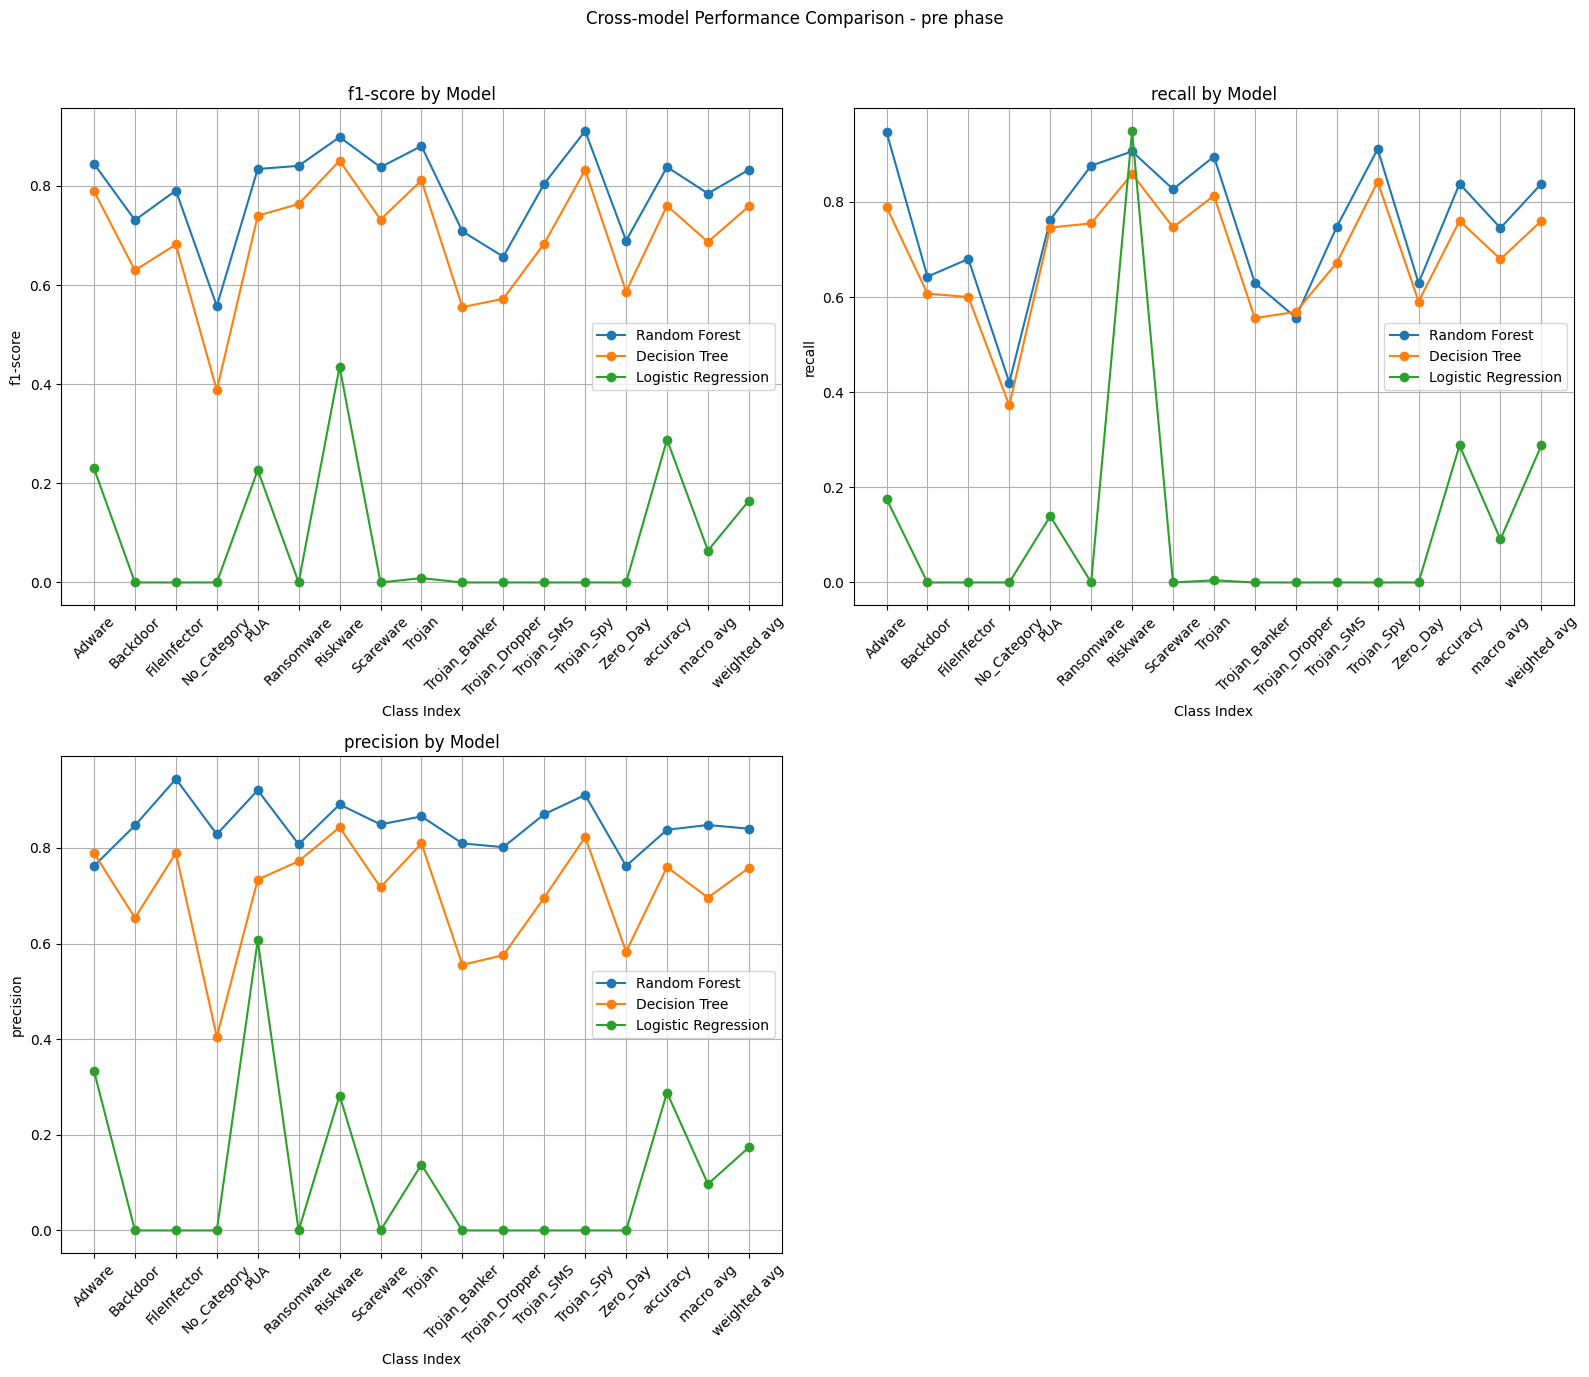

In [69]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(metric=["f1-score", "recall", "precision"])


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


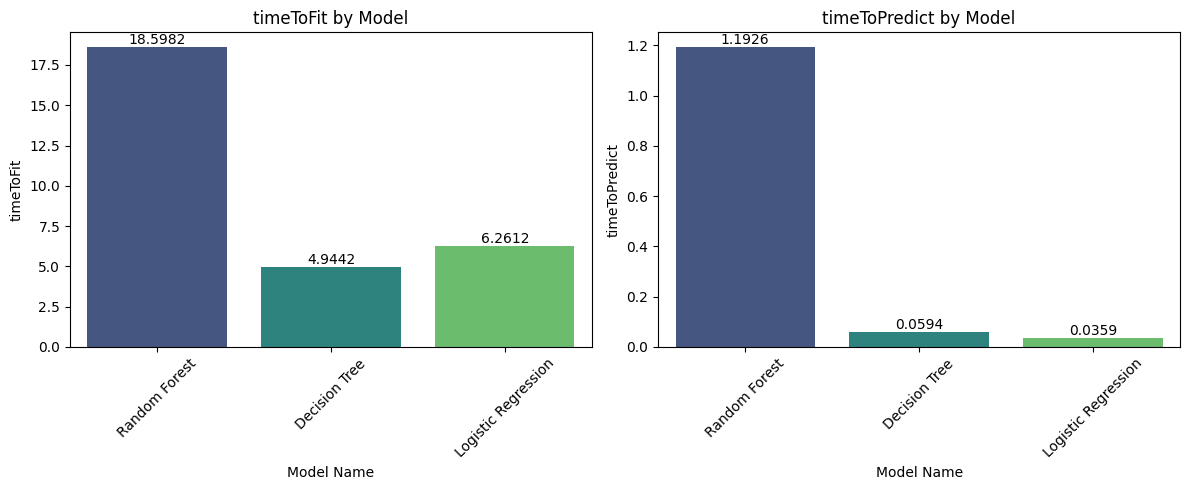

id            timeStamp  \
0  3b6fe625cb1b7625e9b79b521625f3db2791f7d08519d0...  2025-04-24 15:34:11   
0  9556a4c7f58827c413990d4d22b79484d32cc2f5e99620...  2025-04-24 15:34:10   
0  84360435ab3e284fc22ec20d0782940aca1db8884734fa...  2025-04-24 15:34:10   

          comments            modelName currentPhase  \
0  wiLL THIS work?        Random Forest          pre   
0  wiLL THIS work?        Decision Tree          pre   
0  wiLL THIS work?  Logistic Regression          pre   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  18.598150   
0  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   4.944167   
0  {'C': 1.0, 'class_weight': None, 'dual': False...   6.261239   

   timeToPredict classification_report  accuracy_val  accuracy_test  \
0       1.192554                  None      0.838136             -1   
0       0.059423                  None      0.760105             -1   
0       0.035927                  None      0.288174             -1   

   precision_val  precision_test  recall_val  recall_test  f1-score_val  \
0       0.840305              -1    0.838136           -1      0.832592   
0       0.758424              -1    0.760105           -1      0.759110   
0       0.173690              -1    0.288174           -1      0.164798   

   f1-score_test  
0             -1  
0             -1  
0             -1

In [70]:
metrics_df = pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"])
metrics_df

### Intra-model Evaluation (pre-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

There going to be 3 rows and 3 columns


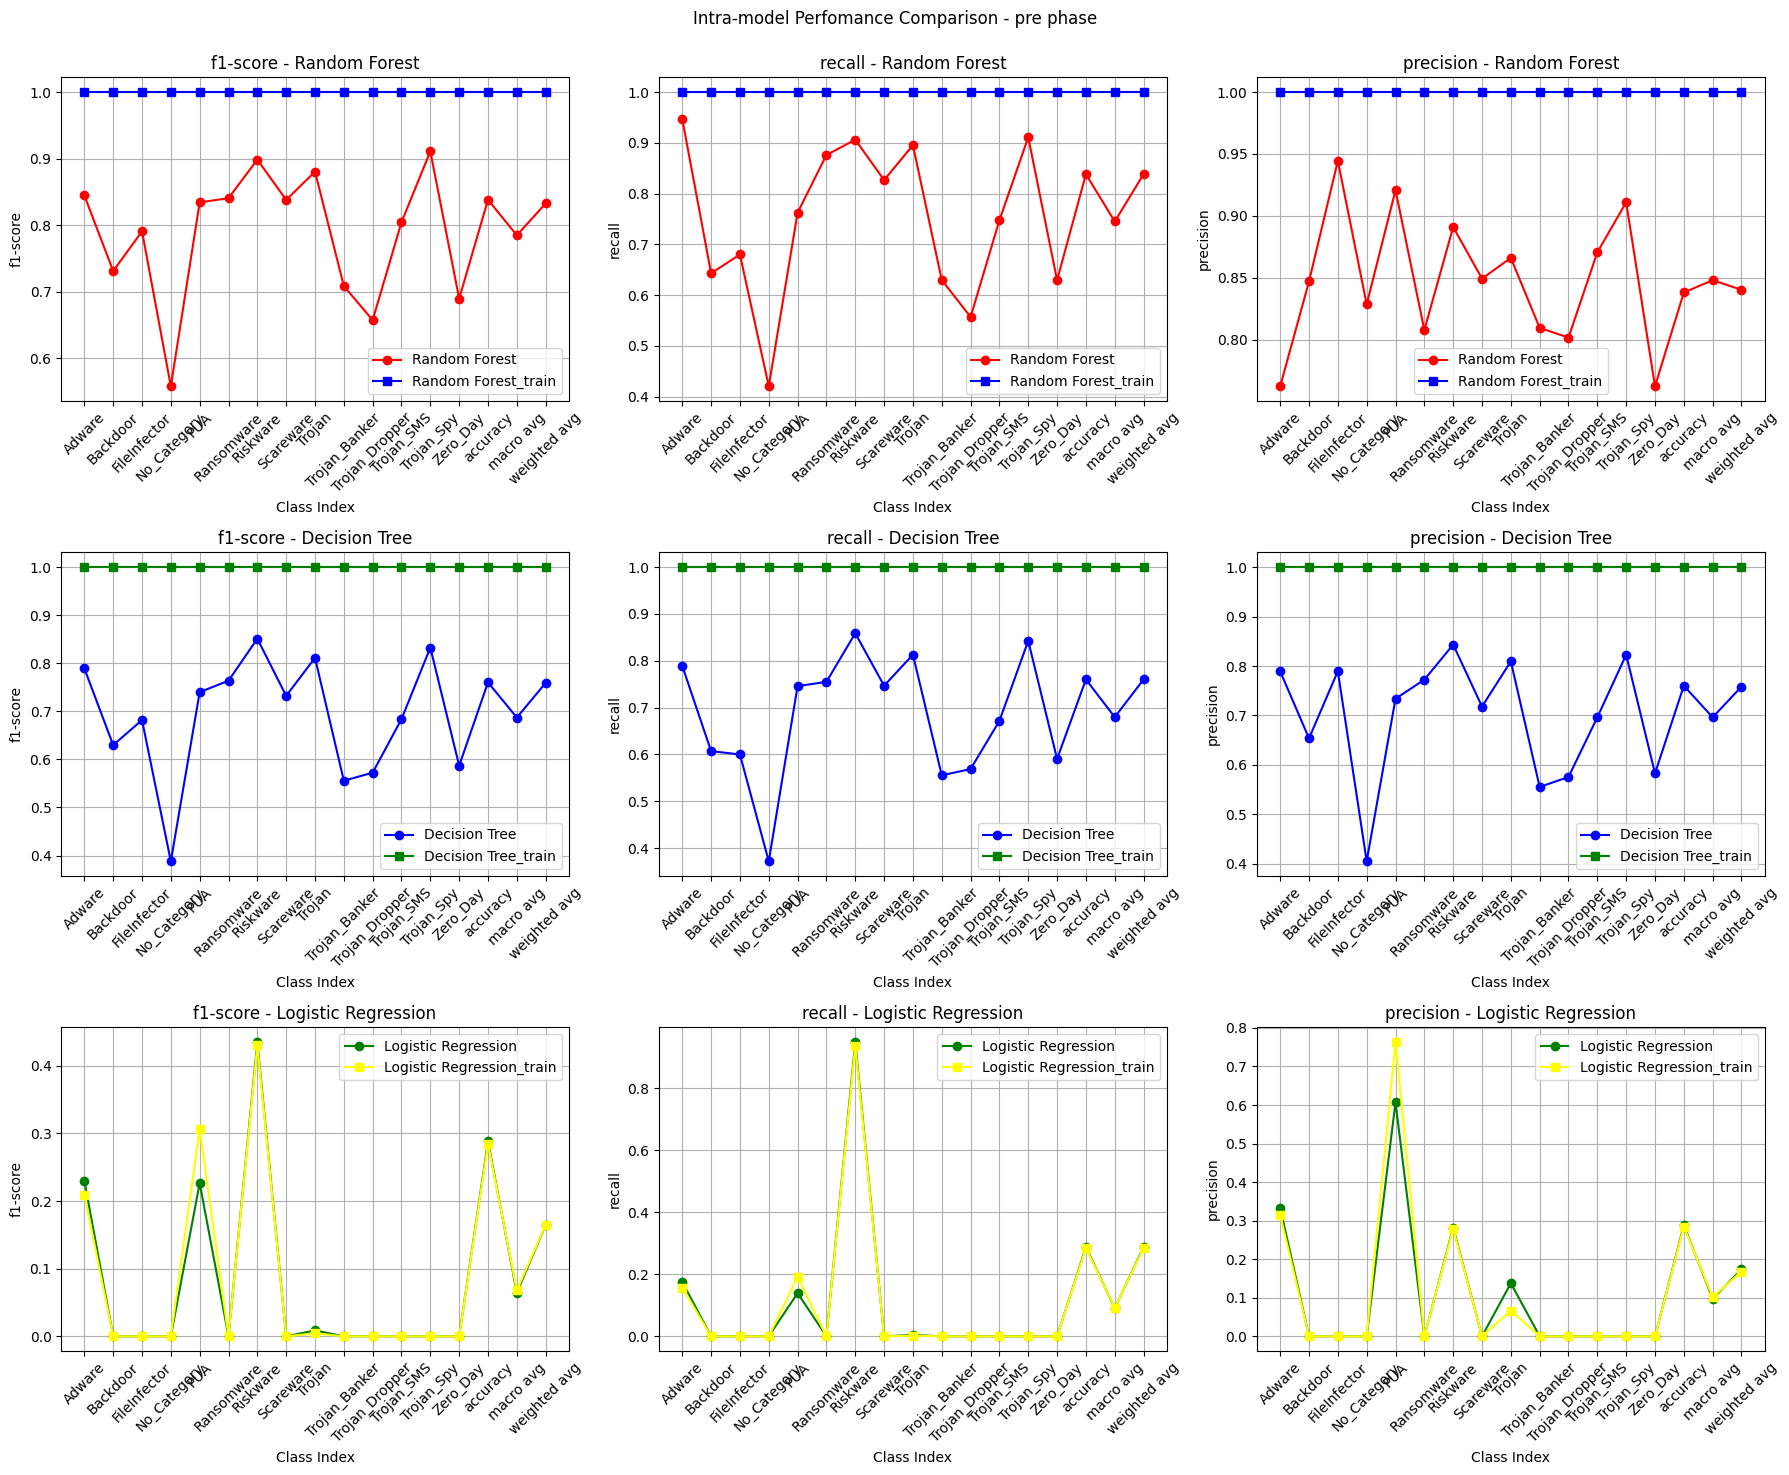

In [71]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(metrics=["f1-score", "recall", "precision"])

### Residual analysis (pre-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Random Forest
Plotting: Decision Tree
Plotting: Logistic Regression


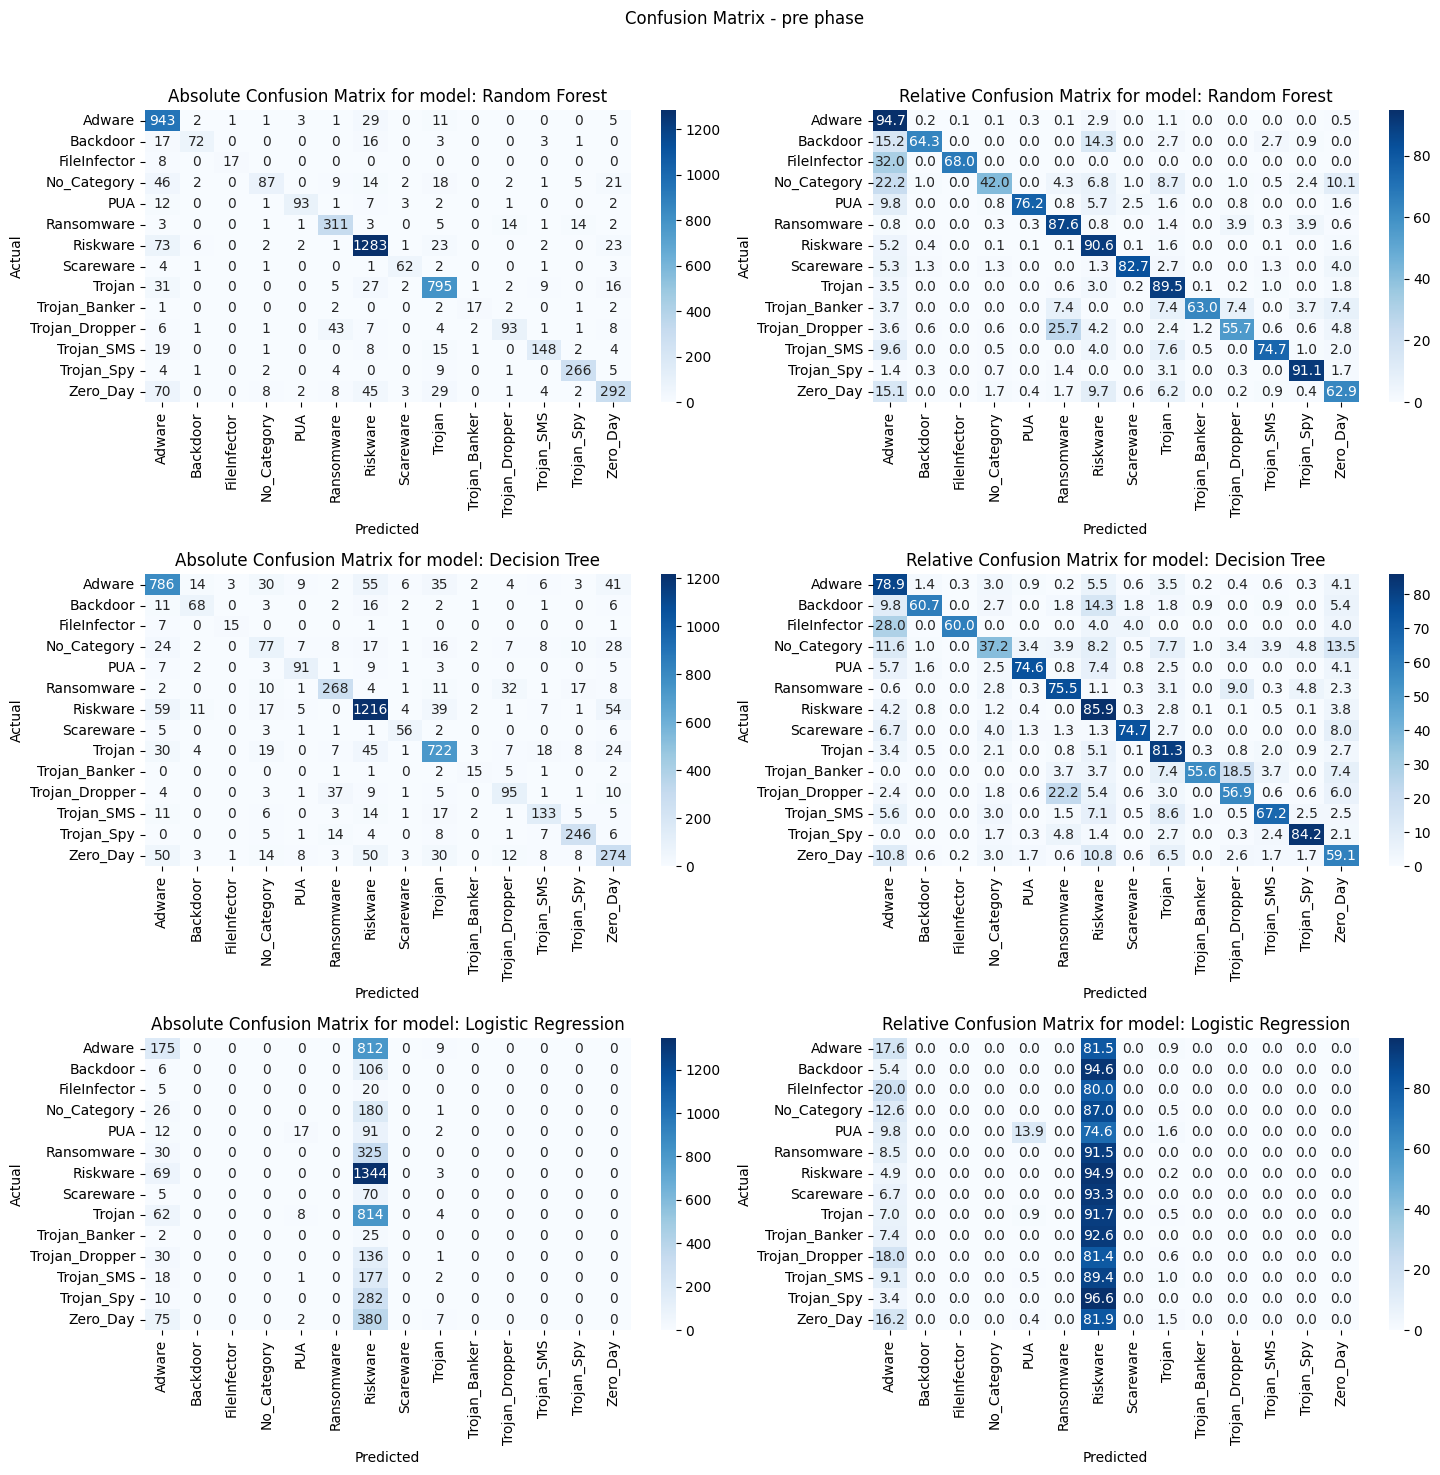

{'ensembled': 32688     8
 46651     8
 27555    13
 47358     8
 33633     3
          ..
 31888     8
 33840     3
 35718     6
 36945     6
 38099     6
 Length: 865, dtype: int64,
 'tree-based': 32688     8
 42208    12
 46651     8
 13497     3
 37307     6
          ..
 29263     8
 36945     6
 14009     5
 19939     6
 38099     6
 Length: 1282, dtype: int64,
 'logistic': 8718      0
 5961      0
 32688     8
 42208    12
 46651     8
          ..
 43422    12
 33882     3
 33656     3
 32607     8
 8923      0
 Length: 3804, dtype: int64}

In [72]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix()
residuals

### Feature importances (pre-tuning)

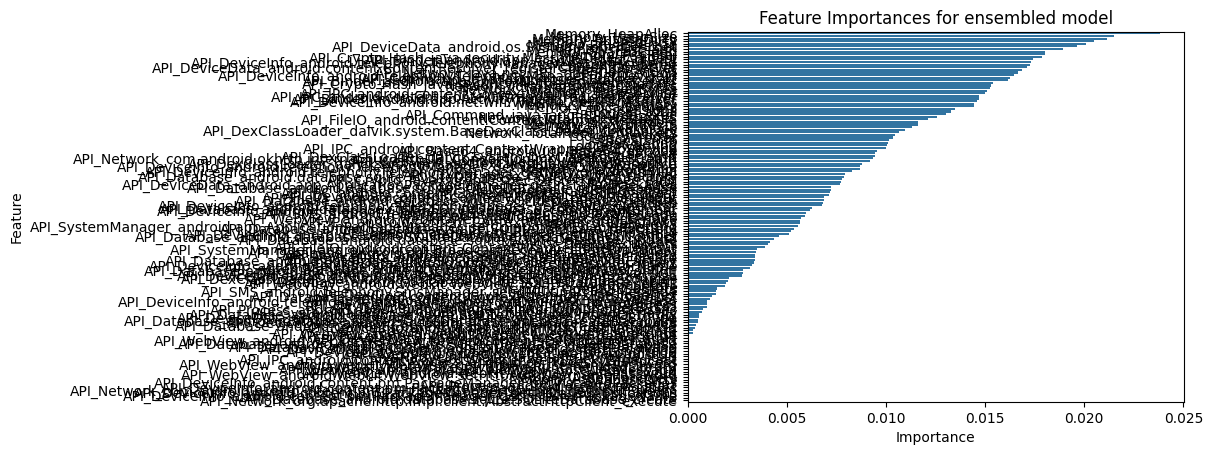

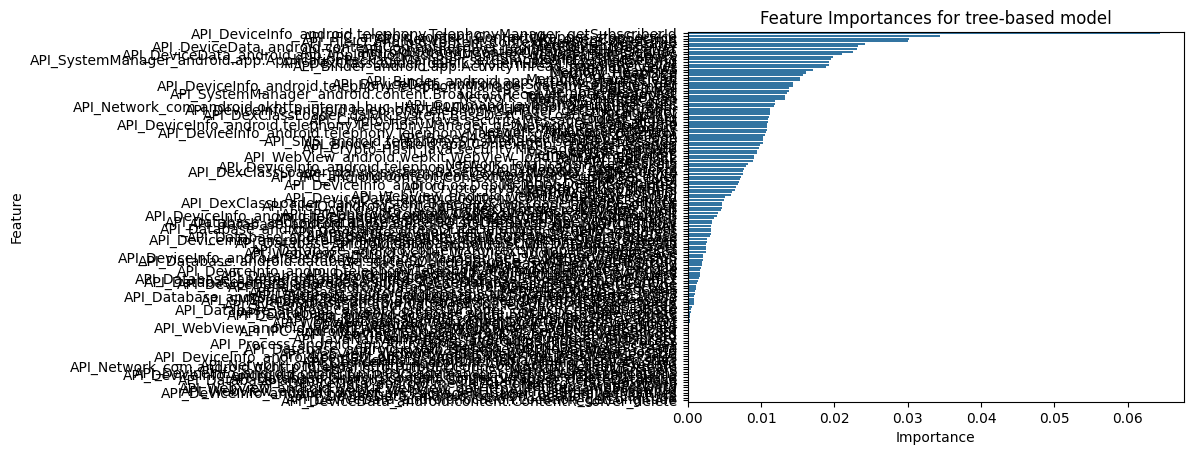

{'ensembled':                                               Feature  Importance
 8                                    Memory_HeapAlloc    0.023821
 7                                     Memory_HeapSize    0.021477
 3                                 Memory_PrivateDirty    0.021158
 2                                  Memory_SharedDirty    0.020513
 5                                 Memory_PrivateClean    0.020071
 ..                                                ...         ...
 99  API_Network_com.android.okhttp.internal.http.H...    0.000000
 93  API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 92  API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 63  API_Database_android.database.sqlite.SQLiteDat...    0.000000
 97  API_Network_org.apache.http.impl.client.Abstra...    0.000000
 
 [142 rows x 2 columns],
 'tree-based':                                                Feature  Importance
 78   API_DeviceInfo_android.telephony.TelephonyMana...    0.064386
 68   

In [73]:
importances_dfs = pipeline_manager.pipelines_analysis.plot_feature_importance()
importances_dfs

## Hyperparameter Optimization
1. Bind the grids to each model in each pipeline
2. Start all optimizations in parallel

In [74]:
pipeline_manager.pipeline_state = "in"

In [75]:
rf_grid = {
      'n_estimators': [50, 100, 150, 200], 
      'max_depth': [None, 10, 20, 30], 
      'min_samples_split': [2, 5, 10], 
      'min_samples_leaf': [1, 2, 4,]
}

dt_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.01, 0.1]

} 

In [76]:
modelNameToOptimizer = {
      "Random Forest": {
            "optimizer_type": "bayes",
            "param_grid": rf_grid,
            "max_iter": 2
      },
      "Decision Tree": {
            "optimizer_type": "bayes",
            "param_grid": dt_grid,
            "max_iter": 2
      }
      }

In [77]:
pipeline_manager.all_pipelines_execute(methodName="model_selection.fit_models", 
                                       current_phase=pipeline_manager.pipeline_state,
                                       modelNameToOptimizer=modelNameToOptimizer)

Optimizing model Random Forest
Optimizing model Decision Tree
All models have been fitted and made predictions in parallel.
Pipeline linear in category not-baseline has executed model_selection.fit_models. Result is: None
All models have been fitted and made predictions in parallel.
Pipeline logistic in category baseline has executed model_selection.fit_models. Result is: None
=> Fitting Decision Tree model
 => STARTING OPTIMIZATION FOR Decision Tree
Fitting 5 folds for each of 1 candidates, totalling 5 fits
=> Fitting Random Forest model
 => STARTING OPTIMIZATION FOR Random Forest
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ccp_alpha=0.01, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=5;, score=0.582 total time=   2.7s
[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=5;, score=0.563 total time=   2.6s
[CV 3/5] END ccp_alpha=0.01, criterion=entro

{'not-baseline': {'linear': None, 'tree-based': None, 'ensembled': None},
 'baseline': {'logistic': None}}

Check predictions, best model, optimizer 

In [78]:
model_results = pipeline_manager.all_pipelines_execute(methodName="model_selection.evaluate_and_store_models", 
                                                       exclude_baseline=True,
                                                       comments=comments, 
                                                       current_phase=pipeline_manager.pipeline_state)

All models have been evaluated.
Pipeline linear in category not-baseline has executed model_selection.evaluate_and_store_models. Result is: Empty DataFrame
Columns: []
Index: []
Evaluating Decision Tree in in phase
METRIC RESULTS FOR Decision Tree => F1: 0.5624691572853183, Precision: 0.5672190264040294, Recall: 0.5800898203592815, Accuracy: 0.5800898203592815


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

Evaluating Random Forest in in phase
METRIC RESULTS FOR Random Forest => F1: 0.8110183912093598, Precision: 0.8278091397128903, Recall: 0.8201721556886228, Accuracy: 0.8201721556886228
All models have been evaluated.
****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
                               You tried to write {'id': '004554d01d182bc1b2eb7be5002abbc0458da93e6bbbc1de0991094fed5d617a', 'timeStamp': '2025-04-24 15:37:32', 'comments': 'wiLL THIS work?', 'modelName': 'Decision Tree', 'currentPhase': 'in', 'features_used': ['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean', 'Memory_SwapPssDirty', 'Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree', 'Memory_Views', 'Memory_ViewRootImpl', 'Memory_AppContexts', 'Memory_Activities', 'Memory_Assets', 'Memory_AssetManagers', 'Memory_LocalBinders', 'Memory_ProxyBinders', 'Memory_ParcelMemory', 'Memory_ParcelC

## In-tuning evalaution

### Cross-Model Evaluation (in-tuning)

In [79]:
pipeline_manager.pipelines_analysis._compute_classification_report().T

Adware  Backdoor FileInfector No_Category       PUA Ransomware  \
precision  0.721673  0.888889          1.0    0.838235  0.917526   0.774436   
recall     0.952811  0.571429         0.48    0.275362  0.729508   0.870423   
f1-score   0.821289  0.695652     0.648649    0.414545  0.812785   0.819629   
support       996.0     112.0         25.0       207.0     122.0      355.0   
precision  0.495665  0.215116          0.0         0.0     0.456   0.546218   
recall     0.688755  0.330357          0.0         0.0  0.467213   0.732394   
f1-score   0.576471  0.260563          0.0         0.0  0.461538   0.625752   
support       996.0     112.0         25.0       207.0     122.0      355.0   

           Riskware Scareware    Trojan Trojan_Banker Trojan_Dropper  \
precision  0.879334  0.808219  0.846809      0.888889       0.843137   
recall      0.89548  0.786667  0.896396      0.592593        0.51497   
f1-score   0.887334  0.797297  0.870897      0.711111       0.639405   
support      1416.0      75.0     888.0          27.0          167.0   
precision  0.717077      0.55  0.622967           0.0       0.633803   
recall     0.699859  0.586667  0.690315           0.0       0.269461   
f1-score   0.708363  0.567742  0.654915           0.0       0.378151   
support      1416.0      75.0     888.0          27.0          167.0   

          Trojan_SMS Trojan_Spy  Zero_Day  accuracy macro avg weighted avg  \
precision       0.88   0.910345  0.770492  0.820172  0.854856     0.827809   
recall      0.666667    0.90411  0.607759  0.820172  0.696012     0.820172   
f1-score    0.758621   0.907216  0.679518  0.820172  0.747425     0.811018   
support        198.0      292.0     464.0  0.820172    5344.0       5344.0   
precision   0.272727   0.898058       0.5   0.58009  0.421974     0.567219   
recall       0.30303   0.633562  0.262931   0.58009   0.40461      0.58009   
f1-score    0.287081   0.742972  0.344633   0.58009  0.400584     0.562469   
support        198.0      292.0     464.0   0.58009    5344.0       5344.0   

               modelName  
precision  Random Forest  
recall     Random Forest  
f1-score   Random Forest  
support    Random Forest  
precision  Decision Tree  
recall     Decision Tree  
f1-score   Decision Tree  
support    Decision Tree

Model names: ['Random Forest' 'Decision Tree']
Plotting: Random Forest
Plotting: Decision Tree
Model names: ['Random Forest' 'Decision Tree']
Plotting: Random Forest
Plotting: Decision Tree
Model names: ['Random Forest' 'Decision Tree']
Plotting: Random Forest
Plotting: Decision Tree


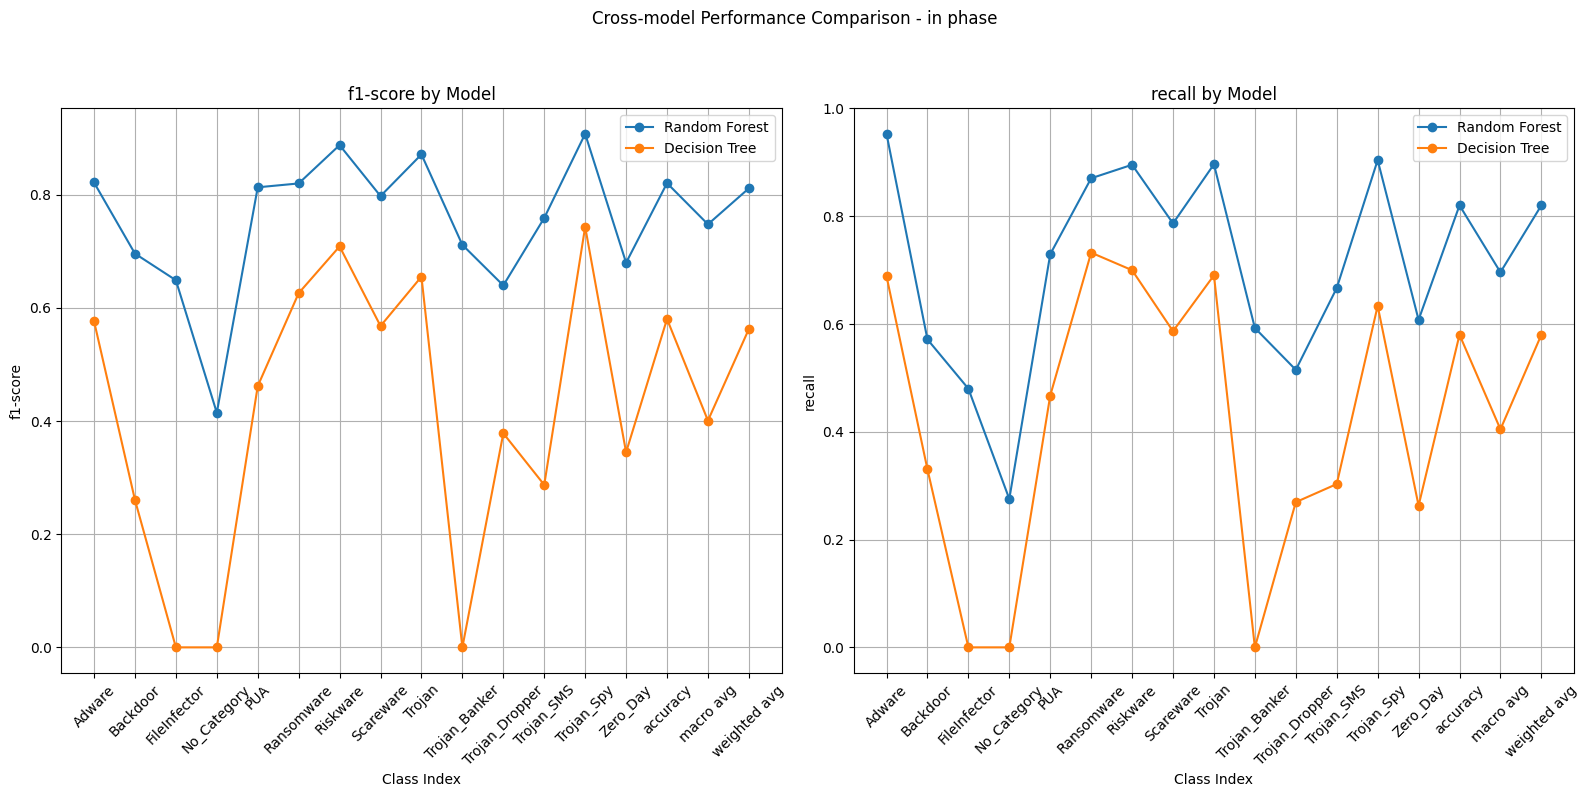

In [80]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(metric=["f1-score", "recall", "precision"])

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


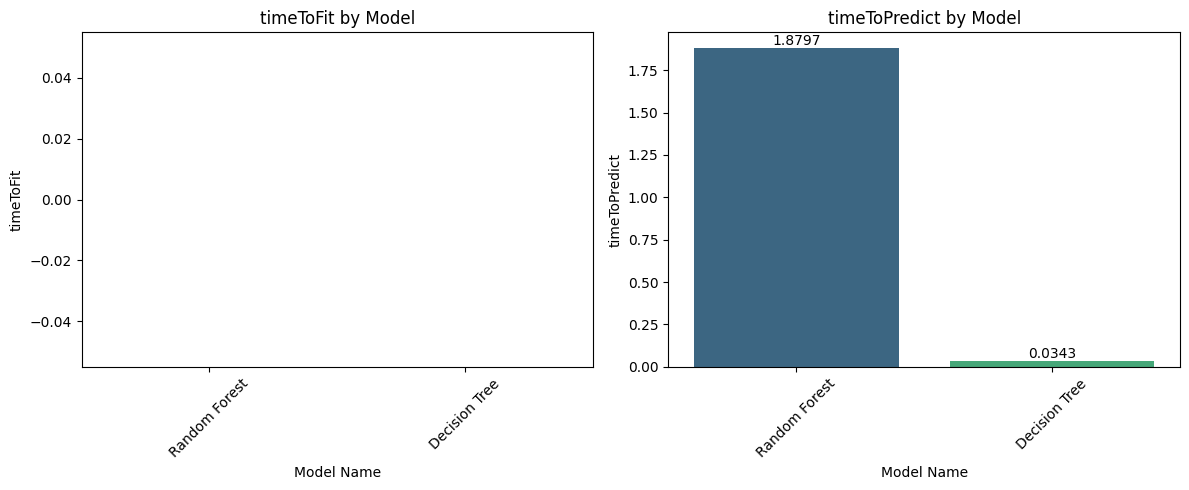

id            timeStamp  \
0  f74a642dfc0ee3812c626a4b50a6d9eb49a4f16cb7b01d...  2025-04-24 15:37:33   
0  004554d01d182bc1b2eb7be5002abbc0458da93e6bbbc1...  2025-04-24 15:37:32   

          comments      modelName currentPhase  \
0  wiLL THIS work?  Random Forest           in   
0  wiLL THIS work?  Decision Tree           in   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters timeToFit  timeToPredict  \
0  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...      None       1.879738   
0  {'ccp_alpha': 0.01, 'class_weight': None, 'cri...      None       0.034330   

  classification_report  accuracy_val  accuracy_test  precision_val  \
0                  None      0.820172             -1       0.827809   
0                  None      0.580090             -1       0.567219   

   precision_test  recall_val  recall_test  f1-score_val  f1-score_test  
0              -1    0.820172           -1      0.811018             -1  
0              -1    0.580090           -1      0.562469             -1

In [81]:
pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"])
# Note I still have not added a way to extract the fitting time from the in-tuning phase


### Intra-model Evaluation (in-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

There going to be 2 rows and 3 columns


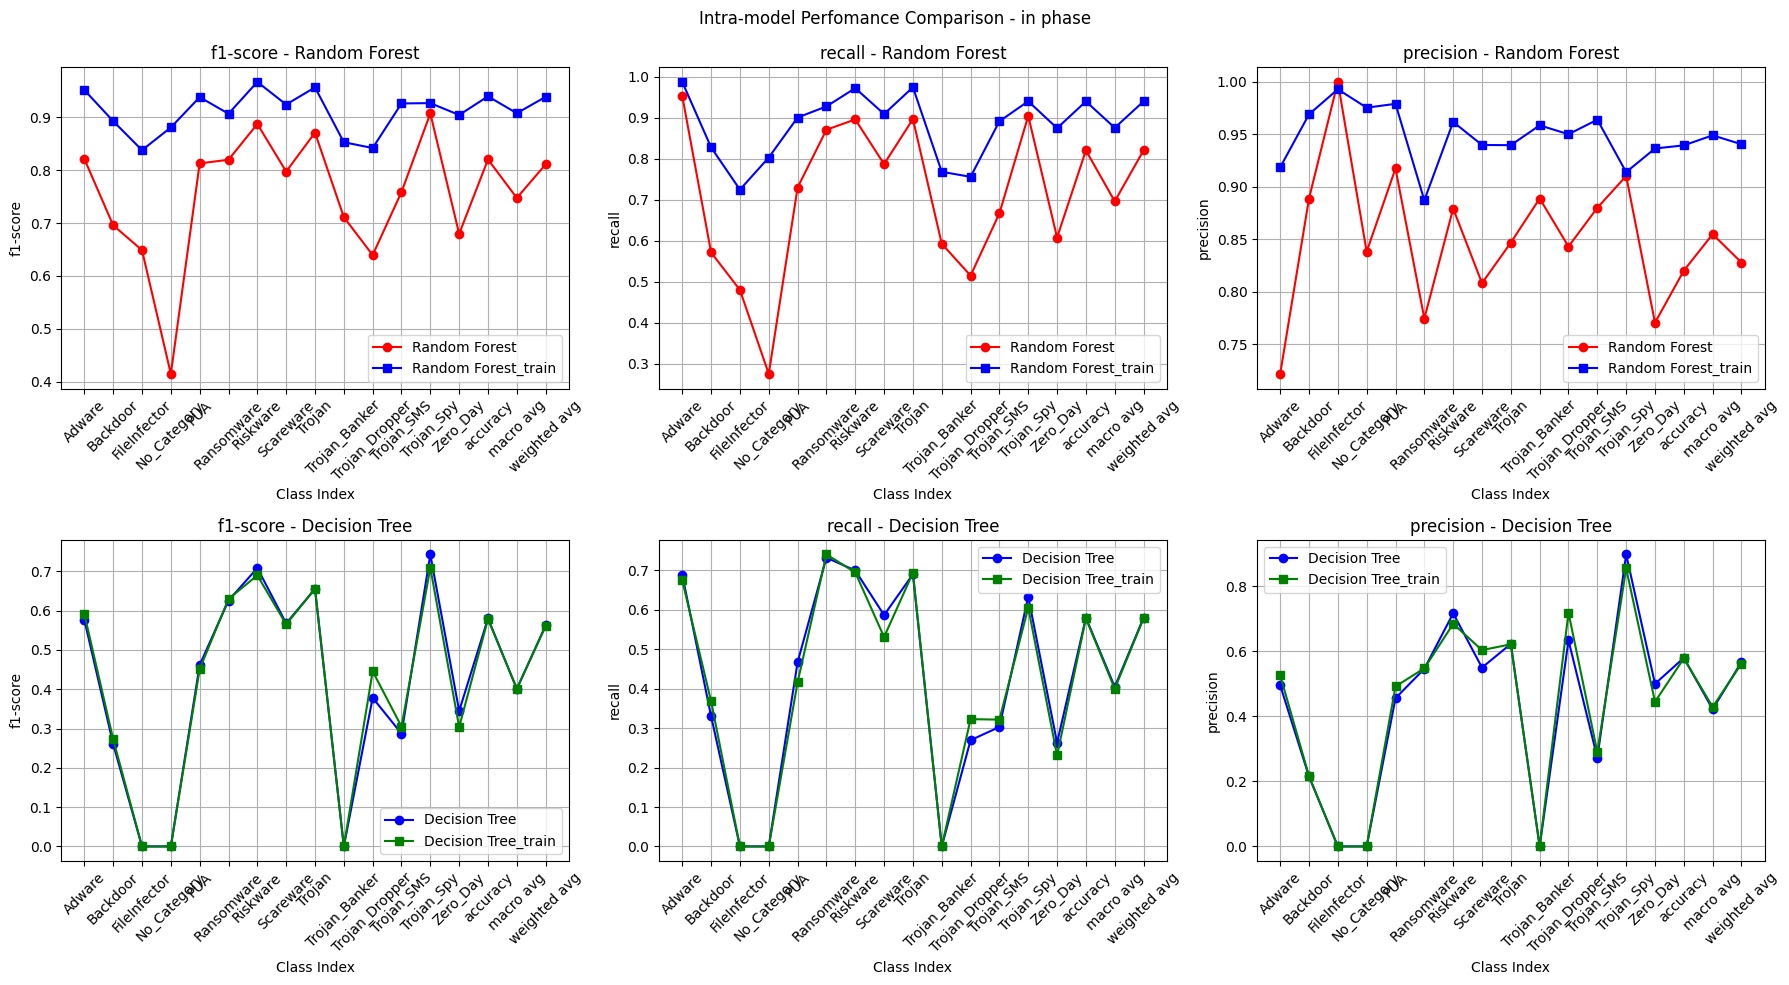

In [82]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(metrics=["f1-score", "recall", "precision"])

### Residual analysis (in-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Random Forest
Plotting: Decision Tree


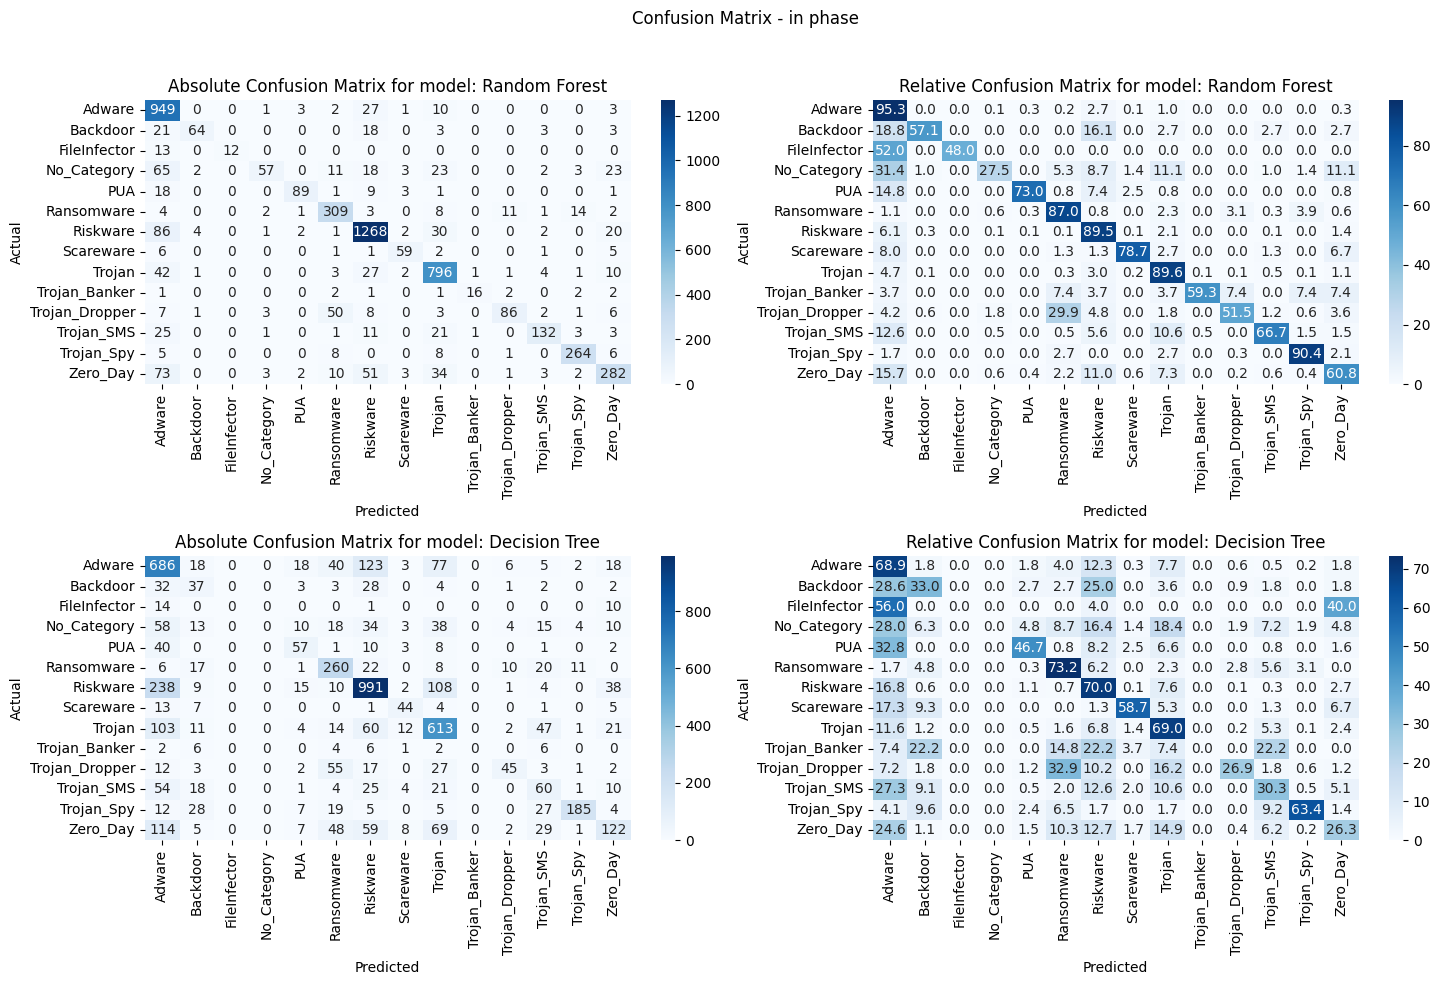

{'ensembled': 32688     8
 46651     8
 13497     3
 27555    13
 47358     8
          ..
 33840     3
 35718     6
 36945     6
 33882     3
 38099     6
 Length: 961, dtype: int64,
 'tree-based': 32688     8
 42208    12
 46651     8
 3727      0
 13497     3
          ..
 48766     5
 19939     6
 33882     3
 33656     3
 38099     6
 Length: 2244, dtype: int64}

In [83]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix()
residuals

### Feature importances (in-tuning)

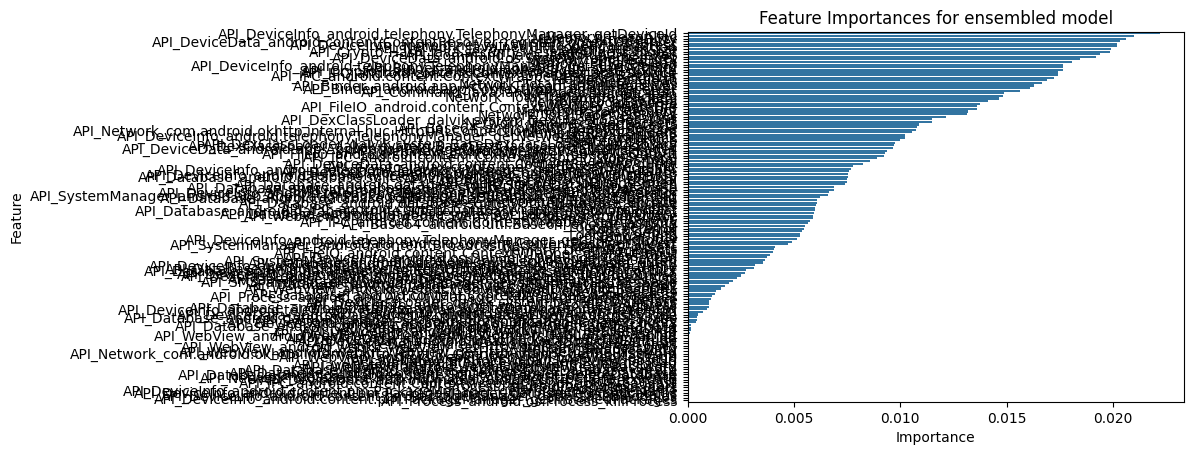

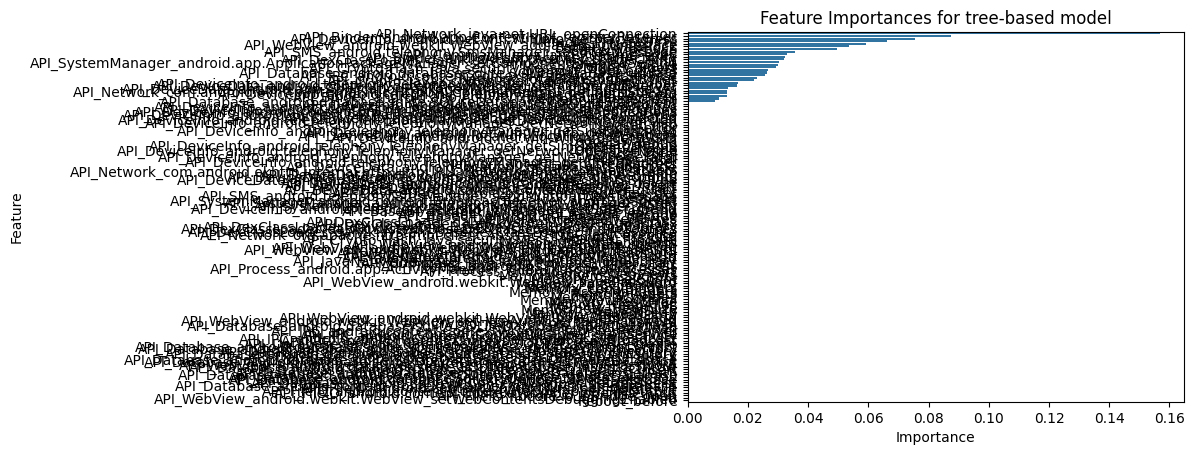

{'ensembled':                                                Feature  Importance
 77   API_DeviceInfo_android.telephony.TelephonyMana...    0.022207
 8                                     Memory_HeapAlloc    0.020996
 3                                  Memory_PrivateDirty    0.020593
 116  API_DeviceData_android.content.ContentResolver...    0.020325
 83   API_DeviceInfo_android.net.wifi.WifiInfo_getMa...    0.020197
 ..                                                 ...         ...
 92   API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 93   API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 94   API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 95   API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 25          API_Process_android.os.Process_killProcess    0.000000
 
 [142 rows x 2 columns],
 'tree-based':                                                Feature  Importance
 96             API_Network_java.net.URL_openConnection    0.1

In [84]:
importances_dfs = pipeline_manager.pipelines_analysis.plot_feature_importance()
importances_dfs

## Optimizer Covergance
Before we proceed, note that you can access the optimizser object (grid, random or bayes) as per shown in the following example. You may see more detailed information on the tuning process there. For now, we limit ourselves to solely plot the convergence map of the bayes optimizer

Questions:
- what can further be analyzed from this process in order to get better insights?

In [85]:
pipeline_manager.pipelines["not-baseline"]["ensembled"].model_selection.list_of_models["Random Forest"].tuning_states["in"].assesment # just an example

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Random Forest',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': 1.8797378540039062,
 'classification_report': None,
 'accuracy': 0.8201721556886228,
 'precision': 0.8278091397128903,
 'recall': 0.8201721556886228,
 'f1-score': 0.8110183912093598,
 'predictions_val': array([6, 6, 0, ..., 8, 0, 0]),
 'predictions_train': array([8, 0, 0, ..., 8, 6, 8]),
 'predictions_test': None,
 'model_sklearn': RandomForestClassifier(max_depth=30, min_samples_leaf=4, n_estimators=200)}

In [86]:
pipeline_manager.pipelines["not-baseline"]["ensembled"].model_selection.list_of_models["Random Forest"].tuning_states["in"].cv_tuner # just an example

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=2,
              random_state=42, scoring='accuracy',
              search_spaces={'max_depth': [None, 10, 20, 30],
                             'min_samples_leaf': [1, 2, 4],
                             'min_samples_split': [2, 5, 10],
                             'n_estimators': [50, 100, 150, 200]},
              verbose=3)

Pipeline ensembled in category not-baseline has executed model_selection.plot_convergence. Result is: None
Pipeline linear in category not-baseline has executed model_selection.plot_convergence. Result is: None
Pipeline tree-based in category not-baseline has executed model_selection.plot_convergence. Result is: None
Pipeline logistic in category baseline has executed model_selection.plot_convergence. Result is: None


{'not-baseline': {'ensembled': None, 'linear': None, 'tree-based': None},
 'baseline': {'logistic': None}}

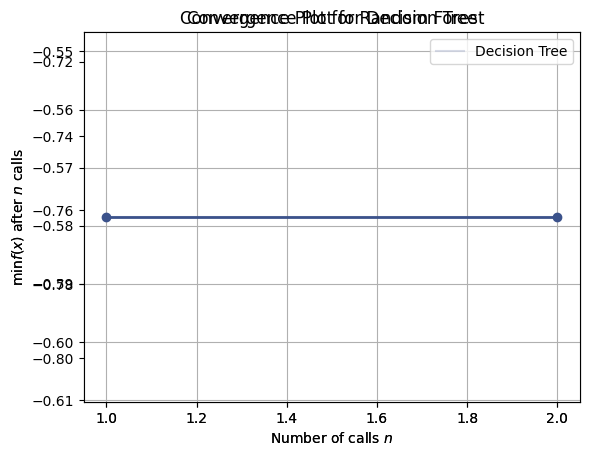

In [87]:
pipeline_manager.all_pipelines_execute(methodName="model_selection.plot_convergence")

there is a clearly a bug in this plot. To be solved...

# Post-tuning Evaluation
Lets start off by selecting the best perfoming model

In [88]:
best_model, best_score = pipeline_manager.select_best_performing_model(metric="precision")

Best performing model: Random Forest with precision 0.8278


In [89]:
pipeline_manager.fit_final_models()

=> Fitting Random Forest model
Sklearn model: RandomForestClassifier(max_depth=30, min_samples_leaf=4, n_estimators=200)
!> Started fitting Random Forest
X_train_combined: (48095, 142)
Lenght of X_data: 48095
		 => Fitted Random Forest. Took 32.79793310165405 seconds
=> Predicting Random Forest model
!> Started predicting Random Forest


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


		 => Predicted Random Forest. Took 2.008474111557007 seconds
Fitted and predicted model Random Forest
All models have been fitted and made predictions in parallel.
=> Fitting Logistic Regression model
Sklearn model: LogisticRegression()
!> Started fitting Logistic Regression
X_train_combined: (48095, 142)
Lenght of X_data: 48095


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


		 => Fitted Logistic Regression. Took 5.038069009780884 seconds
=> Predicting Logistic Regression model
!> Started predicting Logistic Regression
		 => Predicted Logistic Regression. Took 0.05830192565917969 seconds
Fitted and predicted model Logistic Regression
All models have been fitted and made predictions in parallel.


In [90]:
pipeline_manager.evaluate_store_final_models()

Evaluating Random Forest in post phase
METRIC RESULTS FOR Random Forest => F1: 0.8093378163029612, Precision: 0.8224318618110422, Recall: 0.8183008982035929, Accuracy: 0.8183008982035929
All models have been evaluated.
****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
                               You tried to write {'id': '1c0ccd3319e698aa161c70516a7ee991ef8441bfe536cb548ee6b40f6c57e8b6', 'timeStamp': '2025-04-24 15:38:33', 'comments': 'wiLL THIS work?', 'modelName': 'Random Forest', 'currentPhase': 'post', 'features_used': ['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean', 'Memory_SwapPssDirty', 'Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree', 'Memory_Views', 'Memory_ViewRootImpl', 'Memory_AppContexts', 'Memory_Activities', 'Memory_Assets', 'Memory_AssetManagers', 'Memory_LocalBinders', 'Memory_ProxyBinders', 'Memory_ParcelMemory', 'Memory_Par

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

All models have been evaluated.
****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
                               You tried to write {'id': '7453fe56b0e7ed07947996449f0fc7328c298b4b17c9167d22be160769caf0ed', 'timeStamp': '2025-04-24 15:38:36', 'comments': 'wiLL THIS work?', 'modelName': 'Logistic Regression', 'currentPhase': 'post', 'features_used': ['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean', 'Memory_SwapPssDirty', 'Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree', 'Memory_Views', 'Memory_ViewRootImpl', 'Memory_AppContexts', 'Memory_Activities', 'Memory_Assets', 'Memory_AssetManagers', 'Memory_LocalBinders', 'Memory_ProxyBinders', 'Memory_ParcelMemory', 'Memory_ParcelCount', 'Memory_DeathRecipients', 'Memory_OpenSSLSockets', 'Memory_WebViews', 'API_Process_android.os.Process_start', 'API_Process_android.app.ActivityManager_killBackgroundProce

### Metric Evaluation

In [91]:
pipeline_manager.pipeline_state = "post"

### Cross-Model Evaluation (post-tuning)

In [92]:
class_report_df =pipeline_manager.pipelines_analysis._compute_classification_report(include_training=True)
class_report_df

precision         recall       f1-score        support  \
Adware               0.747346       0.946237       0.835113         1116.0   
Backdoor             0.855556       0.669565        0.75122          115.0   
FileInfector         0.933333       0.518519       0.666667           27.0   
No_Category          0.814286       0.301587       0.440154          189.0   
PUA                      0.91       0.722222        0.80531          126.0   
Ransomware           0.790155       0.871429       0.828804          350.0   
Riskware             0.882096       0.888563       0.885318         1364.0   
Scareware            0.840909       0.840909       0.840909           88.0   
Trojan               0.820426       0.902469       0.859494          810.0   
Trojan_Banker             0.8       0.606061       0.689655           33.0   
Trojan_Dropper       0.826087        0.45509       0.586873          167.0   
Trojan_SMS           0.882716         0.6875       0.772973          208.0   
Trojan_Spy           0.888889       0.867133       0.877876          286.0   
Zero_Day             0.749304       0.578495       0.652913          465.0   
accuracy             0.818301       0.818301       0.818301       0.818301   
macro avg             0.83865       0.703984        0.74952         5344.0   
weighted avg         0.822432       0.818301       0.809338         5344.0   
modelName       Random Forest  Random Forest  Random Forest  Random Forest   

                          precision               recall             f1-score  \
Adware                     0.850888             0.897336             0.873495   
Backdoor                   0.864773             0.742439              0.79895   
FileInfector               0.859756             0.632287             0.728682   
No_Category                0.859079             0.735072             0.792252   
PUA                        0.888158             0.809075             0.846774   
Ransomware                 0.792329             0.831479             0.811432   
Riskware                   0.880149             0.896099             0.888052   
Scareware                  0.854734             0.812577             0.833123   
Trojan                      0.84721             0.890979             0.868543   
Trojan_Banker              0.825581             0.663551             0.735751   
Trojan_Dropper             0.854795             0.667142               0.7494   
Trojan_SMS                 0.859649             0.788053             0.822295   
Trojan_Spy                 0.817176             0.840267              0.82856   
Zero_Day                   0.838267             0.776614             0.806264   
accuracy                   0.853103             0.853103             0.853103   
macro avg                  0.849467             0.784498             0.813112   
weighted avg               0.853359             0.853103             0.852022   
modelName       Random Forest_train  Random Forest_train  Random Forest_train   

                            support            precision               recall  \
Adware                       9984.0                  0.4             0.080645   
Backdoor                     1025.0                  0.0                  0.0   
FileInfector                  223.0                  0.0                  0.0   
No_Category                  1725.0                  0.0                  0.0   
PUA                          1168.0             0.820513             0.253968   
Ransomware                   3056.0                  0.0                  0.0   
Riskware                    12637.0             0.262877              0.97654   
Scareware                     811.0                  0.0                  0.0   
Trojan                       7549.0             0.230769             0.003704   
Trojan_Banker                 214.0                  0.0                  0.0   
Trojan_Dropper               1403.0                  0.0                  0.0   
Trojan_SMS               

Model names: ['Random Forest' 'Logistic Regression']
Plotting: Random Forest
Plotting: Logistic Regression
Model names: ['Random Forest' 'Logistic Regression']
Plotting: Random Forest
Plotting: Logistic Regression
Model names: ['Random Forest' 'Logistic Regression']
Plotting: Random Forest
Plotting: Logistic Regression


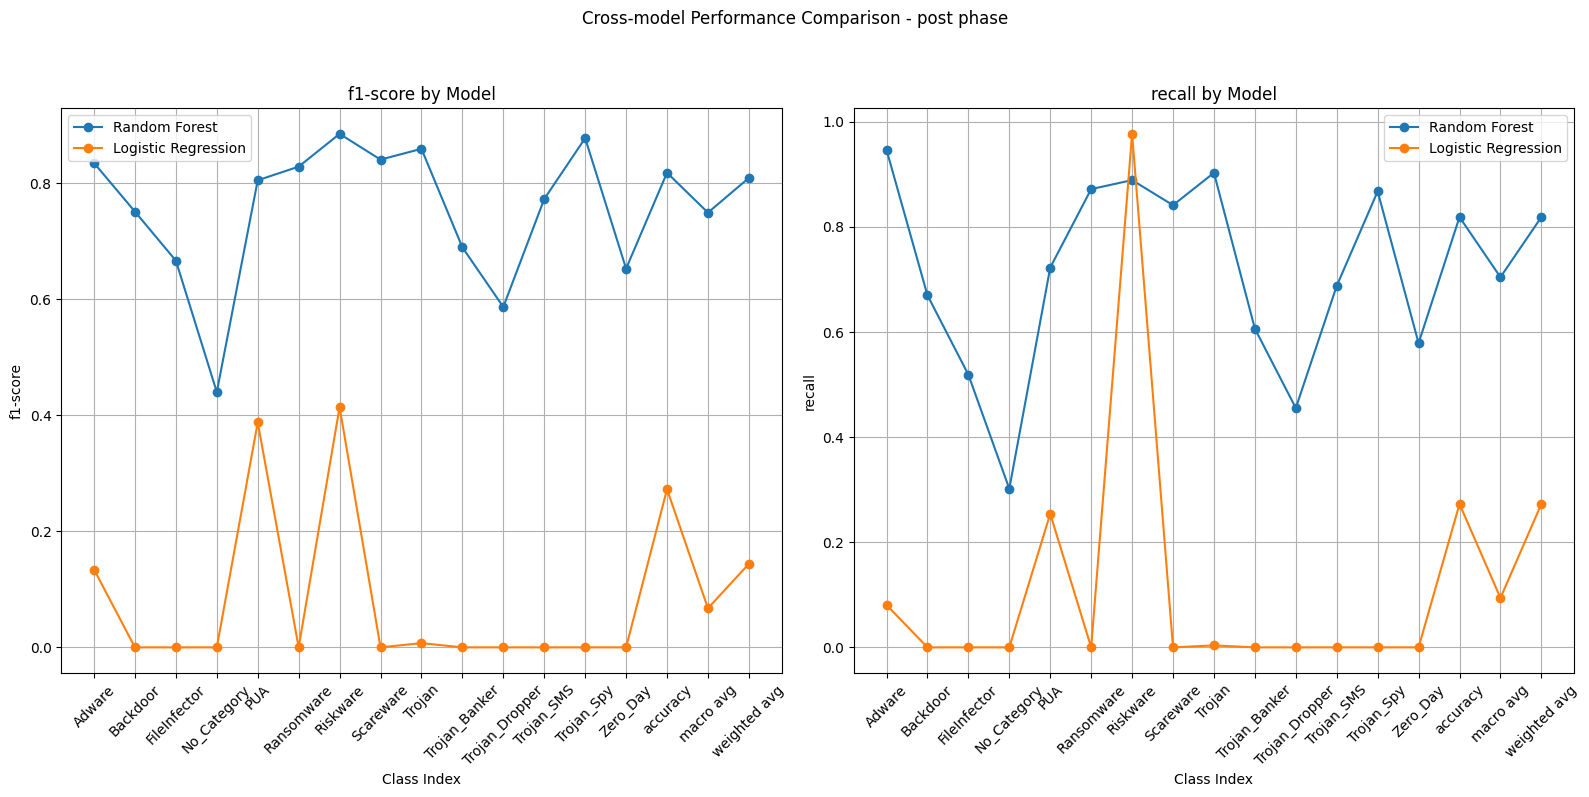

In [93]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(metric=["f1-score", "recall", "precision"])

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


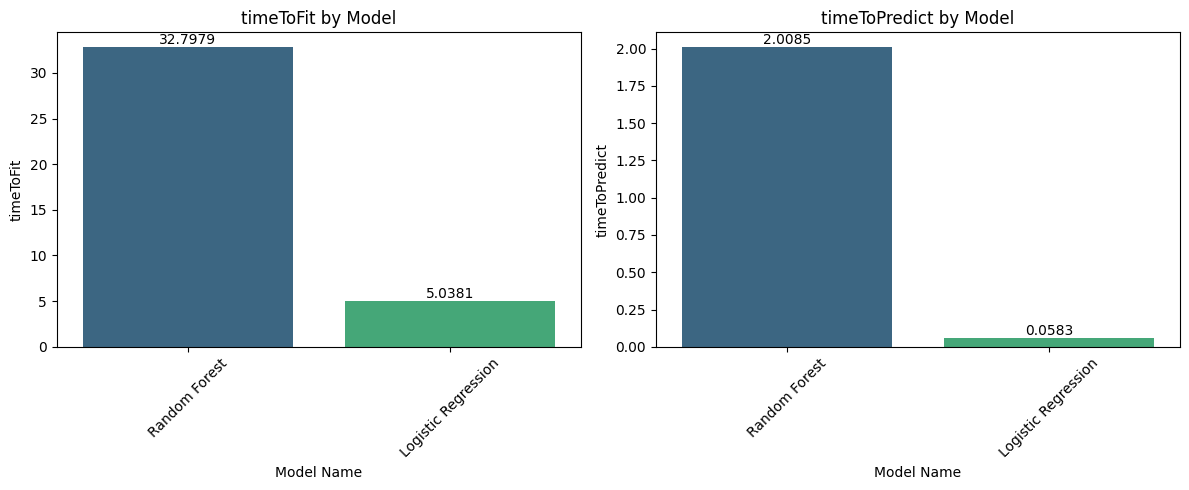

id            timeStamp  \
0  1c0ccd3319e698aa161c70516a7ee991ef8441bfe536cb...  2025-04-24 15:38:33   
0  7453fe56b0e7ed07947996449f0fc7328c298b4b17c916...  2025-04-24 15:38:36   

          comments            modelName currentPhase  \
0  wiLL THIS work?        Random Forest         post   
0  wiLL THIS work?  Logistic Regression         post   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  32.797933   
0  {'C': 1.0, 'class_weight': None, 'dual': False...   5.038069   

   timeToPredict classification_report  accuracy_test  accuracy_val  \
0       2.008474                  None       0.818301            -1   
0       0.058302                  None       0.272642            -1   

   precision_test  precision_val  recall_test  recall_val  f1-score_test  \
0        0.822432             -1     0.818301          -1       0.809338   
0        0.204954             -1     0.272642          -1       0.144013   

   f1-score_val  
0            -1  
0            -1

In [94]:
pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"])


### Intra-model Evaluation (post-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

There going to be 2 rows and 3 columns


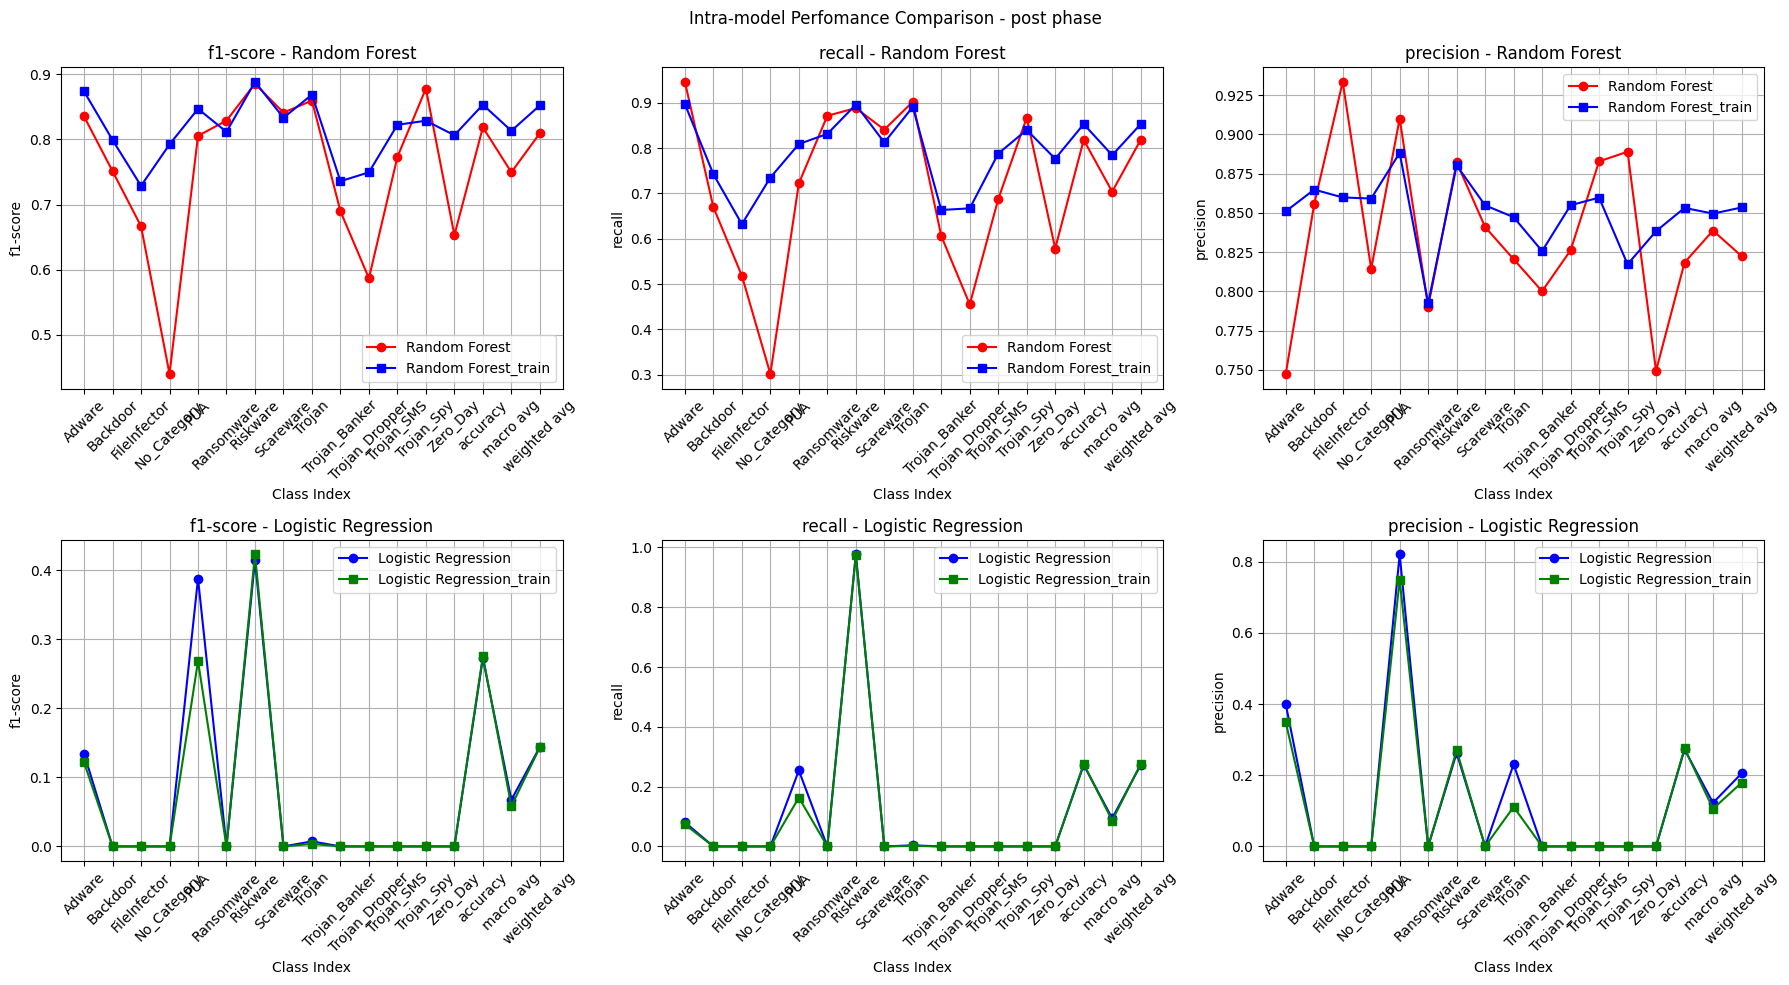

In [95]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(metrics=["f1-score", "recall", "precision"])


### Residual analysis (post-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Random Forest
Plotting: Logistic Regression


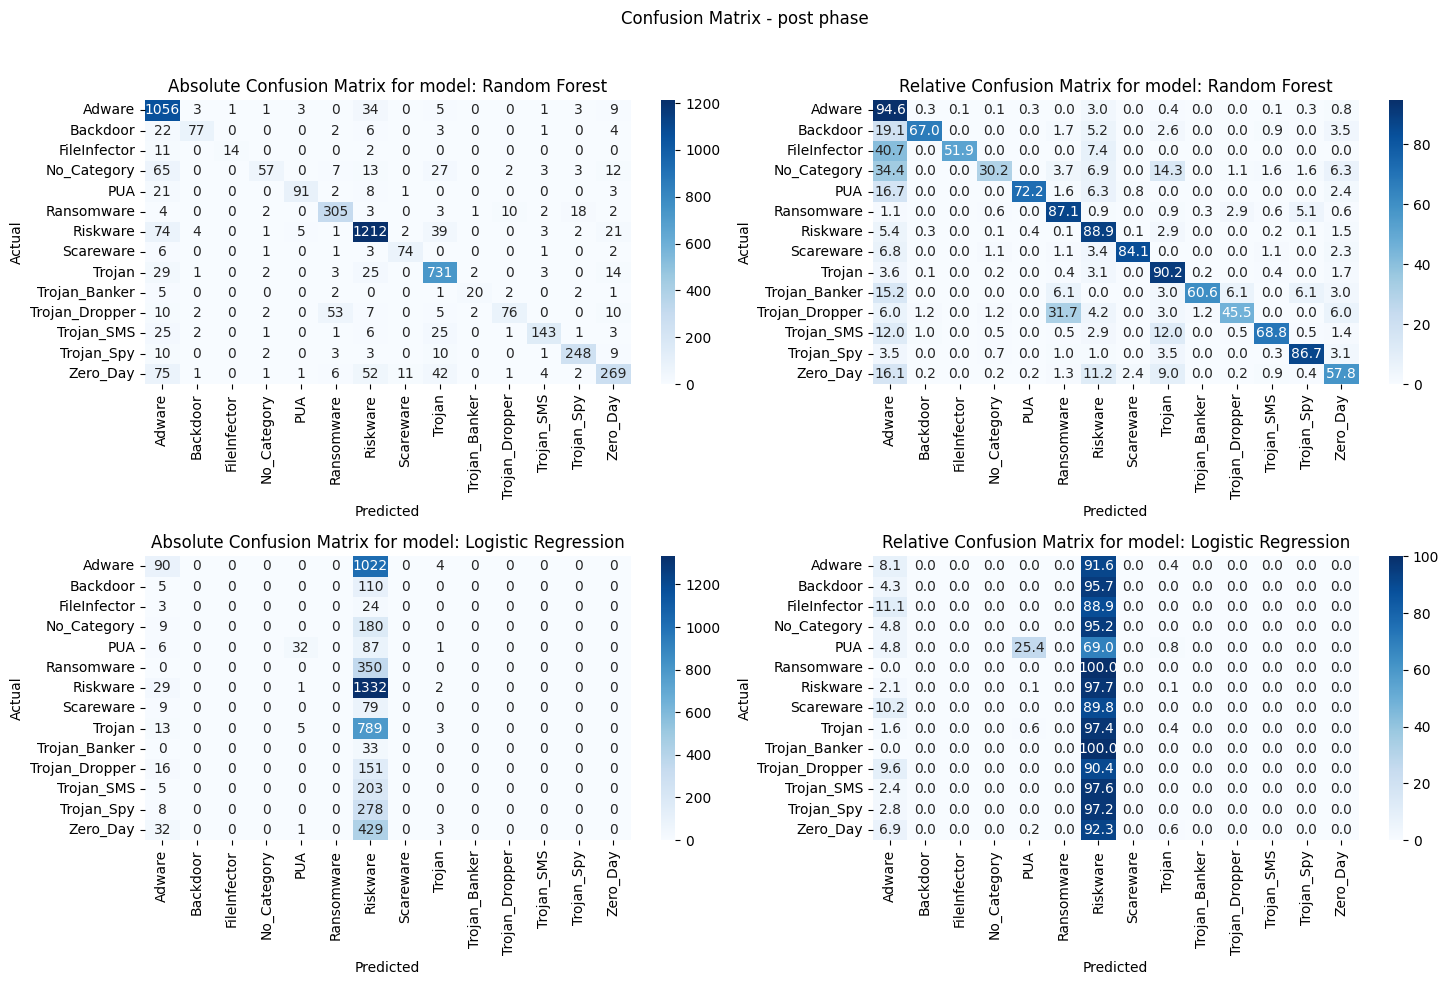

{'ensembled': 28550    13
 33765     3
 33487     3
 50381     1
 4027      0
          ..
 41688    11
 13445     3
 15721    10
 42115    12
 49176     5
 Length: 971, dtype: int64,
 'logistic': 28550    13
 43091    12
 8287      0
 47969     8
 29839     8
          ..
 53065     4
 49176     5
 30395     8
 4491      0
 2304      0
 Length: 3887, dtype: int64}

In [96]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix()
residuals

### Feature importances (post-tuning)

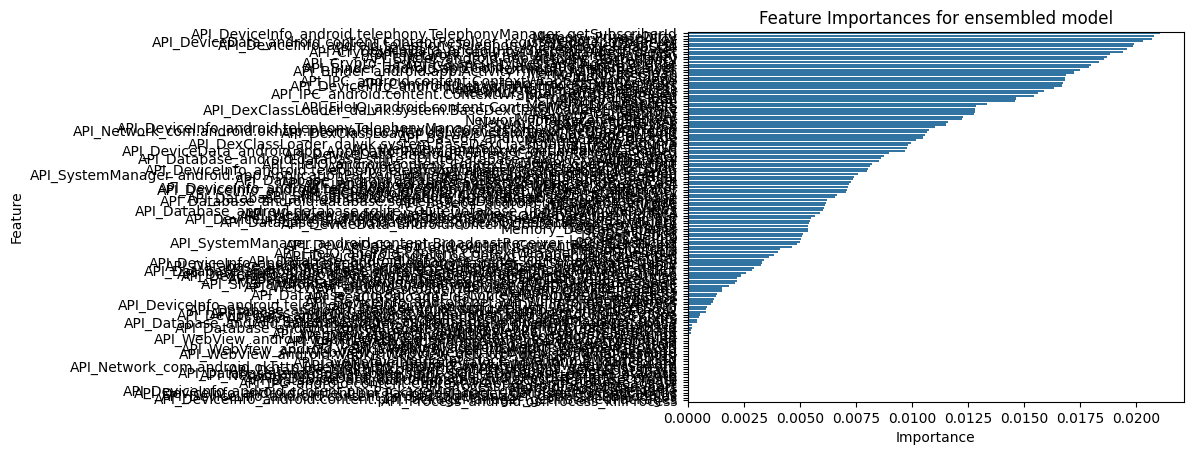

{'ensembled':                                                Feature  Importance
 78   API_DeviceInfo_android.telephony.TelephonyMana...    0.021056
 3                                  Memory_PrivateDirty    0.020782
 8                                     Memory_HeapAlloc    0.020686
 116  API_DeviceData_android.content.ContentResolver...    0.020280
 77   API_DeviceInfo_android.telephony.TelephonyMana...    0.019897
 ..                                                 ...         ...
 92   API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 93   API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 94   API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 95   API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 25          API_Process_android.os.Process_killProcess    0.000000
 
 [142 rows x 2 columns]}

In [97]:
importances_dfs = pipeline_manager.pipelines_analysis.plot_feature_importance()
importances_dfs

## Saving Best Model

In [98]:
#pipeline_manager.store_best_performing_sklearn_model_object(includeModelObject=False)

In [99]:
#pipeline_manager.store_pipelines(includeModelObject=False) # this is going to heavy in size
